In [1]:
# Importation des librairies.
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import scipy.stats as ss  
import pingouin as pg
from statsmodels.stats.multicomp import MultiComparison
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Importation de la librairie locale et de la fonction tabulate pour formatter les tableaux.
import locale
from tabulate import tabulate

# Options d'affichage.

# Configuration du style de visualisation des graphiques avec un style personnel (pitayasmoothie-dark).
plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")

# Fonction pour formatter des libellés des graphiques.
def autopct_format(p, data, column):
    value = p * data[column].sum() / 100
    return f'{p:.1f}%\n {value:,.0f} €'.replace(',', ' ')

# Définition de classes et fonctions.

In [2]:
class AnalysePrix:
    def __init__(self, df):
        """Initialise la classe avec le DataFrame de données.

        Args:
            df (pandas.DataFrame): Le DataFrame contenant les données.
        """
        self.df = df.dropna(subset=['categ'])
        self.stats_list = []
        
    def analyser_par_categorie(self):
        """Analyse la variable 'price' pour chaque catégorie de produits."""
        for cat in self.df["categ"].unique():
            # Création d'un DataFrame 'references' sans doublons dans la colonne 'id_prod' pour cette catégorie.
            references = self.df.query("categ == @cat").drop_duplicates(subset=["id_prod"])
            # Calcul des statistiques descriptives de la variable 'price' dans le DataFrame 'references'.
            moyenne = round(references['price'].mean(), 2)
            mediane = round(references['price'].median(), 2)
            mode_list = references['price'].mode().tolist()
            if mode_list:
                mode = round(mode_list[0], 2)
            else:
                mode = 0.0
            minimum = round(references['price'].min(), 2)
            maximum = round(references['price'].max(), 2)
            variance = round(references['price'].var(), 2)
            ecart_type = round(references['price'].std(), 2)
            # Ajout des statistiques descriptives de cette catégorie à la liste.
            self.stats_list.append([moyenne, mediane, mode, minimum, maximum, variance, ecart_type])
            
            # Création d'une visualisation pour observer la distribution des prix pour cette catégorie.
            plt.figure(figsize=(15,5))
            ax = sns.histplot(references["price"], kde=True)
            ax.set(title=f"Analyse variable prix catégorie {cat}", xlabel="Prix")
            if ax.lines:
                ax.lines[0].set(color="orange", alpha=0.6)
            ax.axvline(references["price"].mean(), color="crimson", linestyle="dotted", label=f"Moyenne catégorie {cat}")    
            plt.axvline(references["price"].median(), color="white", linestyle="dotted", label=f"Médiane catégorie {cat}")
            plt.legend()
            plt.show()

            # Création d'une visualisation pour observer la répartition des prix pour cette catégorie.
            plt.figure(figsize=(15,5))
            ax = sns.boxplot(x="price", data=references, linewidth=3, color="white", showmeans=True)
            plt.show()

        # Création d'un DataFrame pour stocker les statistiques descriptives de chaque catégorie.
        df_stats = pd.DataFrame(self.stats_list, columns=['Moyenne', 'Médiane', 'Mode', 'Minimum', 'Maximum', 'Variance', 'Ecart-type'], index=self.df["categ"].unique())
        # Affiche le tableau récapitulatif.
        print(tabulate(df_stats, headers='keys', tablefmt='fancy_grid'))


In [3]:
class VerifCorrelationPearson:
    """
    Cette classe permet de vérifier si les conditions pour utiliser la corrélation de Pearson sont remplies.
    """

    def __init__(self, var_dep, var_indep, alpha=0.05):
        """
        Initialise une instance de la classe VerifCorrelationPearson.

        :param var_dep: la variable dépendante
        :param var_indep: la variable indépendante
        :param alpha: le niveau de signification pour les tests statistiques (par défaut 0.05)
        """
        self.var_dep = var_dep
        self.var_indep = var_indep
        self.alpha = alpha

    def tester_normalite(self):
        """
        Teste la normalité des deux variables en utilisant le test de Kolmogorov-Smirnov à deux échantillons.

        :return: True si les deux variables suivent une distribution normale, False sinon
        """
        _, p_value1 = ss.ks_2samp(self.var_dep,list(np.random.normal(np.mean(self.var_dep), np.std(self.var_dep), 1000)))
        _, p_value2 = ss.ks_2samp(self.var_indep,list(np.random.normal(np.mean(self.var_indep), np.std(self.var_indep), 1000)))

        print(f"Résultat du test de normalité (Kolmogorov-Smirnov) pour la variable dependante : p-value = {p_value1}")
        print(f"Résultat du test de normalité (Kolmogorov-Smirnov) pour la variable indépendante : p-value = {p_value2}")

        if p_value1 > self.alpha and p_value2 > self.alpha:
            print("Les deux variables suivent une distribution normale.")
            return True
        else:
            print("Au moins une des variables ne suit pas une distribution normale.")
            return False

    def tracer_qqplots(self):
        """
        Trace les QQ-plots pour les deux variables.
        """
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Trace le QQ-plot pour la variable dependante
        ss.probplot(self.var_dep, dist="norm", plot=axes[0])
        axes[0].set_title("QQ-plot pour la variable dependante")

        # Trace le QQ-plot pour la variable indépendante
        ss.probplot(self.var_indep, dist="norm", plot=axes[1])
        axes[1].set_title("QQ-plot pour la variable indépendante")

        plt.show()

    def tester_homoscedasticite(self):
        """
        Teste l'homoscédasticité des résidus en utilisant le test de Levene.

        :return: True si les résidus présentent une homoscédasticité, False sinon
        """
        # Utilisation de la régression OLS pour calculer les résidus
        X = sm.add_constant(self.var_dep)
        modele = sm.OLS(self.var_indep, X).fit()
        residus = modele.resid

        # Utilisation du test de Levene pour vérifier l'homoscédasticité
        _, p_value = ss.levene(self.var_dep, residus)

        print(f"Résultat du test de Levene pour l'homoscédasticité : p-value = {p_value}")

        if p_value > self.alpha:
            print("Les résidus présentent une homoscédasticité.")
            return True
        else:
            print("Les résidus ont des variances différentes.")
            return False

    def peut_utiliser_pearson(self):
        """
        Vérifie si les conditions pour utiliser la corrélation de Pearson sont remplies en testant la normalité et l'homoscédasticité
        des deux variables.

        :return: True si les conditions sont remplies, False sinon
        """
        normalite = self.tester_normalite()
        self.tracer_qqplots()
        homoscedasticite = self.tester_homoscedasticite()

        if normalite and homoscedasticite:
            print("Les conditions pour utiliser la corrélation de Pearson sont remplies.")
            return True
        else:
            print("Les conditions pour utiliser la corrélation de Pearson ne sont pas remplies.")
            return False


In [4]:
def test_spearman(var_indep, var_dep, alpha=0.05):
    """
    Réalise un test de corrélation de Spearman entre la variable dépendante et la variable indépendante, et trace le scatter plot
    avec la ligne de régression et le coefficient de détermination R2.

    :param var_dep: la variable dépendante
    :param var_indep: la variable indépendante
    :param alpha: le niveau de signification pour le test (par défaut 0.05)
    :return: un tuple contenant la statistique de test et la p-valeur
    """
    corr, p_value = ss.spearmanr(var_indep, var_dep)
    crit = ss.norm.ppf(1-alpha/2)

    print(f"Résultat du test de Spearman : corr = {corr:.2f}, p-value = {p_value:.4f}")

    if abs(corr) > crit:
        print("Il y a une corrélation significative entre les deux variables.")
    else:
        print("Il n'y a pas de corrélation significative entre les deux variables.")

    # Calcul de la ligne de régression et du coefficient de détermination R2
    slope, intercept, r_value, p_value, std_err = ss.linregress(var_indep, var_dep)
    r_squared = r_value ** 2

    # Tracé du scatter plot avec la ligne de régression
    fig, ax = plt.subplots(figsize=(16,8))
    ax.scatter(var_indep, var_dep)
    ax.plot(var_indep, slope*var_indep + intercept, color='red', label='Régression linéaire')
    ax.set_xlabel('Variable indépendante')
    ax.set_ylabel('Variable dépendante')
    ax.legend()
    ax.set_title(f"Test de Spearman : corr = {corr:.2f}, p-value = {p_value:.4f}, R2 = {r_squared:.2f}")
    plt.show()

In [5]:
class AnalyseResidus:
    """
    Cette classe vérifie si les prérequis pour une ANOVA sont satisfaits : 
    
    Elle effectue une analyse des résidus pour une variable dépendante en vérifiant la normalité et
    l'homoscédasticité des résidus pour chaque catégorie d'une variable indépendante catégorique.

    La classe prend en entrée un DataFrame, une variable dépendante et une variable indépendante (catégorique)
    et fournit des méthodes pour vérifier la normalité des résidus à l'aide du test de Kolmogorov-Smirnov,
    afficher les QQ plots des résidus, et vérifier l'homoscédasticité à l'aide du test de Levene.
    """
    def __init__(self, df, var_dependante, var_independante, alpha=0.05):
        """
        Constructeur de la classe AnalyseResidus. Initialise les attributs de la classe et ajuste le modèle ANOVA.
        
        :param df: DataFrame contenant les données à analyser
        :param var_dependante: Nom de la colonne correspondant à la variable dépendante
        :param var_independante: Nom de la colonne correspondant à la variable indépendante catégorique
        :param alpha: Niveau de signification pour les tests (par défaut 0.05)
        """

        self.df = df  # Le DataFrame à analyser
        self.var_dependante = var_dependante  # La variable dépendante à analyser
        self.var_independante = var_independante  # La variable indépendante (catégorique)
        self.alpha = alpha  # Le niveau de signification pour les tests

        # Ajustement du modèle ANOVA en fonction de la variable dépendante et indépendante
        self.modele = smf.ols(f"{var_dependante} ~ C({var_independante})", data=df).fit()

        # Calcul des résidus du modèle ajusté et ajout au DataFrame dans une nouvelle colonne nommée "residus"
        self.df["residus"] = self.modele.resid


    def verifier_normalite(self, cat):
        """
        Vérifie la normalité des résidus pour une catégorie donnée en utilisant le test de Kolmogorov-Smirnov
        et affiche le QQ plot des résidus.
        
        :param cat: Catégorie pour laquelle vérifier la normalité des résidus
        """

        # Récupération des résidus pour la catégorie donnée
        residus = self.df[self.df[self.var_independante] == cat]["residus"]

        # Standardisation des résidus en soustrayant la moyenne et en divisant par l'écart-type
        residus_standardises = (residus - np.mean(residus)) / np.std(residus)

        # Effectue le test de Kolmogorov-Smirnov pour vérifier la normalité
        # Le test compare les résidus standardisés à une distribution normale standard et retourne une p-valeur
        _, p_value = ss.kstest(residus_standardises, 'norm')

        # Affichage de la p-valeur du test de Kolmogorov-Smirnov
        print(f"Normalité des résidus pour {cat} (variable dépendante: {self.var_dependante}): p-valeur = {p_value}")

        # Prendre une décision concernant l'hypothèse nulle en fonction de la p-valeur et du seuil alpha
        if p_value < self.alpha:
            print(f"Rejet de l'hypothèse nulle: Les résidus pour {cat} ne sont PAS normalement distribués.")
        else:
            print(f"Échec à rejeter l'hypothèse nulle: Les résidus pour {cat} sont normalement distribués.")
        # Affichage du QQ plot des résidus standardisés
        # Le QQ plot compare les quantiles des résidus standardisés à ceux d'une distribution normale standard
        # Si les points du QQ plot suivent approximativement une droite, cela suggère que les résidus sont normalement distribués
        plt.figure()
        ss.probplot(residus_standardises, dist="norm", plot=plt)
        plt.title(f"QQ plot pour les résidus de {cat} (variable dépendante: {self.var_dependante})")
        plt.show()


    def verifier_homoscedasticite(self):
        """
        Cette fonction vérifie l'homoscédasticité des résidus pour toutes les catégories en utilisant le test de Levene.
        """

        # Création d'une liste de résidus pour chaque groupe de la variable indépendante
        liste_residus = [self.df[self.df[self.var_independante] == cat]["residus"] for cat in self.df[self.var_independante].unique()]

        # Effectue le test de Levene pour vérifier l'homoscédasticité
        # Le test de Levene compare les variances des résidus entre les groupes et retourne une statistique de test
        # et une p-valeur associée
        statistique, p_value = ss.levene(*liste_residus)

        # Affichage de la p-valeur du test de Levene
        print(f"Test d'homoscédasticité de Levene : p-valeur = {p_value}")

        # Affichage de la conclusion en fonction de la p-valeur
        # Si la p-valeur est inférieure au niveau de signification (alpha), on rejette l'hypothèse nulle
        # et on conclut que les variances ne sont pas égales entre les groupes (violation de l'homoscédasticité)
        if p_value < self.alpha:
            print("Rejet de l'hypothèse nulle : Les variances ne sont PAS égales entre les groupes, l'hypothèse d'homoscédasticité n'est pas vérifiée.")
        # Si la p-valeur est supérieure au niveau de signification (alpha), on ne rejette pas l'hypothèse nulle
        # et on conclut que les variances sont égales entre les groupes (l'homoscédasticité est vérifiée)
        else:
            print("Non-rejet de l'hypothèse nulle : Les variances sont égales entre les groupes, l'hypothèse d'homoscédasticité est vérifiée.")
        
    def analyser_residus(self):
        """
        Analyse les résidus pour la variable dépendante en vérifiant la normalité et l'homoscédasticité
        des résidus pour chaque catégorie de la variable indépendante.
        """

        # Pour chaque catégorie unique de la variable indépendante,
        # vérifier la normalité des résidus en utilisant la méthode verifier_normalite
        for categorie in self.df[self.var_independante].unique():
            self.verifier_normalite(categorie)

        # Vérifier l'homoscédasticité des résidus pour toutes les catégories
        # en utilisant la méthode verifier_homoscedasticite
        self.verifier_homoscedasticite()

In [6]:
# Fonction pour effectuer le test ANOVA de Welch et le test post-hoc de Games-Howell
def anova_gameshowell(dataframe, variable_dependante, variable_independante, alpha=0.05):
    # Test ANOVA de Welch
    anova_result = pg.welch_anova(dv=variable_dependante, between=variable_independante, data=dataframe)
    print(anova_result)

    # Test post-hoc de Games-Howell
    if anova_result["p-unc"].values[0] < alpha:
        print(f"Il y a une différence significative entre les moyennes des groupes.")
        resultat = pg.pairwise_gameshowell(dv=variable_dependante, between=variable_independante, data=dataframe)
        
        # Création d'un DataFrame contenant les différences de moyenne et les intervalles de confiance
        resultat['difference_groupes'] = resultat['A'].map(str) + ' ' + resultat['B'].map(str)
        plot_data = resultat[['difference_groupes', 'diff','hedges']]

        # Création d'un graphique à barres sans intervalles de confiance
        g = sns.barplot(data=plot_data, x="difference_groupes", y='diff')

        # Ajouter des titres et des étiquettes d'axe
        g.set_title("Résultats du test post-hoc de Games-Howell")
        g.set_xlabel("Différences entre les groupes")
        g.set_ylabel("Différence moyenne")

        # Afficher la légende et le graphique
        plt.show()
    else:
        print(f"Il n'y a pas de différence significative entre les moyennes des groupes.")

# 1. Importation, exploration et nettoyage des donnees

Cette première phase d'exploration des csv va suivre les mêmes étapes pour chaque fichier, à savoir :


- Importation des fichiers.
- Création d'une copie dans un DataFrame.
- Affichage des premières lignes.
- Vérification des types de données et la présence de valeurs NaN.
- Nettoyage au vu des résultats obtenus.

In [7]:
# Importation des fichiers.
customers = pd.read_csv("DAN-P6-donnees/customers.csv")
products = pd.read_csv("DAN-P6-donnees/products.csv")
transactions = pd.read_csv("DAN-P6-donnees/transactions.csv")

# Création d'une copie dans un DataFrame.
df_customers = customers.copy()
df_products = products.copy()
df_transactions = transactions.copy()

## 1.1. **customers**

In [8]:
# Affichage des premières lignes et observation de la forme du DataFrame.
print(df_customers.shape)
df_customers.head()

(8623, 3)


,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [9]:
# Affichage de statistiques descriptives sur le DataFrame.
df_customers.describe(include="all")

,client_id,sex,birth
count,8623,8623,8623.000000
unique,8623,2,NaN
top,c_4410,f,NaN
freq,1,4491,NaN
mean,NaN,NaN,1978.280877
std,NaN,NaN,16.919535
min,NaN,NaN,1929.000000
25%,NaN,NaN,1966.000000
50%,NaN,NaN,1979.000000
75%,NaN,NaN,1992.000000


In [10]:
# Vérification des types de données et de la présence de valeurs NaN.
df_customers.info()
df_customers.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


client_id    0
sex          0
birth        0
dtype: int64

In [11]:
# Recherche de lignes entièrement dupliquées. 
df_customers.duplicated().sum()

0

In [12]:
# Recherche de doublons dans la colonne client_id pour tester son unicité.
df_customers.duplicated(subset=["client_id"]).sum()

0

In [13]:
# Vérification des données contenues dans la colonne "sex" et de leur adéquation avec le datatype.
list(df_customers["sex"].unique())

['f', 'm']

In [14]:
# Vérification de la consistance de la convention de nommage.
df_customers.query("~client_id.str.startswith('c_')")

,client_id,sex,birth
2735,ct_0,f,2001
8494,ct_1,m,2001


#### Observations :


* Le DataFrame est composé de 8623 lignes et 3 colonnes.

* Il n'y a pas de valeurs *NaN*.

* Il n'y a pas de lignes dupliquées.

* La colonne **client_id** correspond aux identifiants des clients, on peut voir qu'il y a 8623 clients uniques.

* La colonne **client_id** ne contient pas de doublons ou de valeurs nulles. Nous pouvons donc l'utiliser comme **clé primaire** pour une jointure.

* Les conventions de nommage sont consistantes, avec des **client_id** qui commencent par **"c_"** sauf pour deux valeurs qui commencent par **"ct_"**, nous allons explorer les autres jeux de donnée pour voir comment traiter ces valeurs.

* La colonne **sex** contient uniquement les modalités "f" ou "m" et devrait être de type **"category"**."




### Corrections :

In [15]:
# Transtypage de "sex".
df_customers = df_customers.astype({"sex": "category"})

***

## 1.2 **products**

In [16]:
print(df_products.shape)
df_products.head(10)

(3287, 3)


,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
5,0_1163,9.99,0
6,1_463,36.99,1
7,0_2157,34.99,0
8,0_1915,16.99,0
9,0_389,18.99,0


In [17]:
df_products.describe(include="all")

,id_prod,price,categ
count,3287,3287.000000,3287.000000
unique,3287,NaN,NaN
top,0_1421,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.856641,0.370246
std,NaN,29.847908,0.615387
min,NaN,-1.000000,0.000000
25%,NaN,6.990000,0.000000
50%,NaN,13.060000,0.000000
75%,NaN,22.990000,1.000000


In [18]:
df_products.info()
df_products.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


id_prod    0
price      0
categ      0
dtype: int64

In [19]:
df_products.duplicated().sum()

0

In [20]:
df_products.duplicated(subset=["id_prod"]).sum()

0

In [21]:
# Vérification des données contenues et de leur adéquation avec le datatype.
list(df_products["categ"].unique())

[0, 1, 2]

In [22]:
# Vérification de la consistance de la convention de nommage.
# Tous les "id_prod" appartenant à des produits de la catégorie 0 commencent-ils par 0 ?
products.query("id_prod.str.startswith('0') & categ != 0")

,id_prod,price,categ


In [23]:
# Tous les "id_prod" appartenant à des produits de la catégorie 1 commencent-ils par 1 ?
products.query("id_prod.str.startswith('1') & categ != 1")

,id_prod,price,categ


In [24]:
# Tous les "id_prod" appartenant à des produits de la catégorie 2 commencent-ils par 2 ?
products.query("id_prod.str.startswith('2') & categ != 2")

,id_prod,price,categ


In [25]:
# Y a-t-il des "id_prod" qui n'appartiennent pas à la catégorie 0, 1 ou 2 ?
products.query("~id_prod.str.startswith('0') & ~id_prod.str.startswith('1') & ~id_prod.str.startswith('2')")

,id_prod,price,categ
731,T_0,-1.0,0


In [26]:
# Recherche de prix inférieurs à 0.
df_products.query("price <= 0")

,id_prod,price,categ
731,T_0,-1.0,0


#### Observations :

* Le DataFrame contient 3287 lignes et 3 colonnes.

* Il n'y a pas de valeurs *NaN*.

* Il n'y a pas de lignes dupliquées.

* La colonne **id_prod** correspond aux identifiants des produits, on peut voir qu'il y a 3287 produits uniques.

* La colonne **id_prod** peut être utilisée comme clé primaire.

* La colonne **categ** contient trois modalités, elle devrait être de type **category**.

* Les identifiants produits suivent une convention de nommage consistante, avec un premier chiffre qui correspond à la catégorie, 0, 1 ou 2, un underscore puis une série de chiffres. 

* Un seul produit se démarque du lot avec un identifiant **T_0** et un prix à -1€, nous devons analyser le dernier dataset pour voir comment traiter cette valeur aberrante.


### Corrections :

#### Transtypage de **categ**

In [27]:
df_products = df_products.astype({"categ": "category"})

***

## 1.3 **transactions**

In [28]:
print(df_transactions.shape)
df_transactions.head()

(679532, 4)


,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [29]:
df_transactions.describe(include="all")

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


In [30]:
df_transactions.info()
df_transactions.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

In [31]:
df_transactions.duplicated().sum()

126

In [32]:
df_transactions.duplicated(subset=["date"]).sum()

161

#### Observations :

* Le DataFrame contient 679 532 lignes et 4 colonnes.

* Il n'y a pas de valeurs *NaN*.

* Il y a 126 lignes entièrement dupliquées et 161 doublons dans la colonne **date**.

* La colonne **date** ne devrait contenir que des timestamps or elle contient au moins une valeur préfixée par **test_**, elle devrait être de type **datetime**.



### Corrections :

#### Recherche des valeurs test.

In [33]:
# Requête pour retourner les dates qui contiennent la chaîne de caractères "test".
df_transactions.query("date.str.contains('test')")

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


Toutes les valeurs test semblent avoir le même **id_prod** : **"T_0"**, la même **session_id** : **"s_0"** ; et des **client_id** **"ct_0"** ou **"ct_1"**. Analysons cela de plus près.

In [34]:
# Listons toutes les valeurs contenues dans la colonne "id_prod" pour les valeurs test.
df_transactions.query("date.str.contains('test')").value_counts(subset=["id_prod"])

id_prod
T_0        200
dtype: int64

In [35]:
# Listons toutes les valeurs contenues dans la colonne "session_id" pour les valeurs test.
df_transactions.query("date.str.contains('test')").value_counts(subset=["session_id"])

session_id
s_0           200
dtype: int64

In [36]:
# Listons toutes les valeurs contenues dans la colonne "client_id" pour les valeurs test.
df_transactions.query("date.str.contains('test')").value_counts(subset=["client_id"])

client_id
ct_0         106
ct_1          94
dtype: int64

#### Observations :

* Nous avons ici à faire à 200 transactions tests effectuées le 1 mars 2021 à 2h30.

* Nous retrouvons ici les valeurs anormales que nous avions observé dans les autres datasets, à savoir : **id_prod** : **"T_0"**, **client_id** : **"ct_0"** et **"ct_1"**.

* Nous allons donc supprimer ces transactions tests puisqu'elles ne nous seront pas utiles pour les analyses futures.


In [37]:
# Suppression des valeurs "test" dans les différents DataFrames.
df_transactions = df_transactions.query("~date.str.contains('test')").copy()
df_customers = df_customers.query("~client_id.str.contains('ct')").copy()
df_products = df_products.query("~id_prod.str.contains('T_0')").copy()

In [38]:
df_transactions.duplicated().sum()

0

In [39]:
df_transactions.duplicated(subset=["date"]).sum()

0

L'élimination des valeurs **"test"** nous a permis aussi d'éliminer les lignes entièrement dupliquées ainsi que les doublons dans la colonne date.

#### Transtypage de *date*

In [40]:
df_transactions["date"] = pd.to_datetime(df_transactions["date"])

***

## 1.4 Jointures

In [41]:
# Jointure entre les DataFrame transactions et customers, l'option indicator va nous donner des informations sur le succès de cette jointure. 
df_temp = pd.merge(df_transactions, df_customers, how="outer", on="client_id", indicator="resultat")

# Renommage du résultat de manière plus explicite.
d = {"left_only":"Present dans transactions uniquement", "right_only":"Present customers uniquement", "both":"Present dans transactions et customers"}

df_temp["resultat"] = df_temp["resultat"].map(d)
df_temp


,id_prod,date,session_id,client_id,sex,birth,resultat
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,Present dans transactions et customers
1,0_1627,2022-06-18 05:55:31.816994,s_225494,c_103,f,1986,Present dans transactions et customers
2,0_1104,2023-02-08 17:31:06.898425,s_338755,c_103,f,1986,Present dans transactions et customers
3,0_1390,2021-04-20 06:18:39.939761,s_23078,c_103,f,1986,Present dans transactions et customers
4,0_1547,2022-03-15 19:54:53.904123,s_179629,c_103,f,1986,Present dans transactions et customers
...,...,...,...,...,...,...,...
679348,NaN,NaT,NaN,c_862,f,1956,Present customers uniquement
679349,NaN,NaT,NaN,c_7584,f,1960,Present customers uniquement
679350,NaN,NaT,NaN,c_90,m,2001,Present customers uniquement
679351,NaN,NaT,NaN,c_587,m,1993,Present customers uniquement


In [42]:
# Vérification du résultat de la jointure.
df_temp["resultat"].value_counts()

Present dans transactions et customers    679332
Present customers uniquement                  21
Present dans transactions uniquement           0
Name: resultat, dtype: int64

In [43]:
# Isolation des lignes qui ont jointé uniquement à droite.
df_temp.query("resultat == 'Present customers uniquement'")

,id_prod,date,session_id,client_id,sex,birth,resultat
679332,NaN,NaT,NaN,c_8253,f,2001,Present customers uniquement
679333,NaN,NaT,NaN,c_3789,f,1997,Present customers uniquement
679334,NaN,NaT,NaN,c_4406,f,1998,Present customers uniquement
679335,NaN,NaT,NaN,c_2706,f,1967,Present customers uniquement
679336,NaN,NaT,NaN,c_3443,m,1959,Present customers uniquement
679337,NaN,NaT,NaN,c_4447,m,1956,Present customers uniquement
679338,NaN,NaT,NaN,c_3017,f,1992,Present customers uniquement
679339,NaN,NaT,NaN,c_4086,f,1992,Present customers uniquement
679340,NaN,NaT,NaN,c_6930,m,2004,Present customers uniquement
679341,NaN,NaT,NaN,c_4358,m,1999,Present customers uniquement


Nous avons 21 clients qui n'ont jamais effectués d'achat, nous allons les supprimer.

In [44]:
df_temp = (
           df_temp
           .query("resultat == 'Present dans transactions et customers'")
           .drop(columns="resultat")
           .copy()
         )

In [45]:
# Jointure entre le DataFrame précédemment créé et products. 
df_central = pd.merge(df_temp, df_products, how="outer", on="id_prod", indicator="resultat")

d = {"left_only":"Present dans transactions uniquement", "right_only":"Present products uniquement","both":"Present dans transactions et products"}

df_central["resultat"] = df_central["resultat"].map(d)
df_central

,id_prod,date,session_id,client_id,sex,birth,price,categ,resultat
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986.0,4.18,0,Present dans transactions et products
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,f,1986.0,4.18,0,Present dans transactions et products
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,f,1986.0,4.18,0,Present dans transactions et products
3,0_1518,2021-05-09 11:52:55.100386,s_32104,c_6714,f,1968.0,4.18,0,Present dans transactions et products
4,0_1518,2022-05-30 01:17:07.487046,s_216118,c_6714,f,1968.0,4.18,0,Present dans transactions et products
...,...,...,...,...,...,...,...,...,...
679348,0_1624,NaT,NaN,NaN,NaN,NaN,24.50,0,Present products uniquement
679349,2_86,NaT,NaN,NaN,NaN,NaN,132.36,2,Present products uniquement
679350,0_299,NaT,NaN,NaN,NaN,NaN,22.99,0,Present products uniquement
679351,0_510,NaT,NaN,NaN,NaN,NaN,23.66,0,Present products uniquement


In [46]:
# Vérification du résultat de la jointure.
df_central["resultat"].value_counts()

Present dans transactions et products    679111
Present dans transactions uniquement        221
Present products uniquement                  21
Name: resultat, dtype: int64

In [47]:
# Isolation des lignes qui ont jointé uniquement à droite.
df_central.query("resultat == 'Present products uniquement'")

,id_prod,date,session_id,client_id,sex,birth,price,categ,resultat
679332,0_1016,NaT,NaN,NaN,NaN,NaN,35.06,0,Present products uniquement
679333,0_1780,NaT,NaN,NaN,NaN,NaN,1.67,0,Present products uniquement
679334,0_1062,NaT,NaN,NaN,NaN,NaN,20.08,0,Present products uniquement
679335,0_1119,NaT,NaN,NaN,NaN,NaN,2.99,0,Present products uniquement
679336,0_1014,NaT,NaN,NaN,NaN,NaN,1.15,0,Present products uniquement
679337,1_0,NaT,NaN,NaN,NaN,NaN,31.82,1,Present products uniquement
679338,0_1318,NaT,NaN,NaN,NaN,NaN,20.92,0,Present products uniquement
679339,0_1800,NaT,NaN,NaN,NaN,NaN,22.05,0,Present products uniquement
679340,0_1645,NaT,NaN,NaN,NaN,NaN,2.99,0,Present products uniquement
679341,0_322,NaT,NaN,NaN,NaN,NaN,2.99,0,Present products uniquement


Nous avons 21 produits qui n'ont jamais été vendus, nous allons donc les supprimer pour la suite de nos analyses.

In [48]:
# Isolation des lignes qui ont jointé uniquement à gauche.
df_central.query("resultat == 'Present dans transactions uniquement'").head()

,id_prod,date,session_id,client_id,sex,birth,price,categ,resultat
311747,0_2245,2021-04-22 04:57:20.090378,s_23987,c_6714,f,1968.0,NaN,NaN,Present dans transactions uniquement
311748,0_2245,2021-06-05 17:04:43.982913,s_44481,c_6714,f,1968.0,NaN,NaN,Present dans transactions uniquement
311749,0_2245,2022-04-05 17:04:43.982913,s_189669,c_6714,f,1968.0,NaN,NaN,Present dans transactions uniquement
311750,0_2245,2022-05-05 17:04:43.982913,s_204093,c_6714,f,1968.0,NaN,NaN,Present dans transactions uniquement
311751,0_2245,2022-12-05 17:04:43.982913,s_307520,c_6714,f,1968.0,NaN,NaN,Present dans transactions uniquement


In [49]:
# Listons les valeurs uniques de ces références.
list(df_central.query("resultat == 'Present dans transactions uniquement'")["id_prod"].unique())

['0_2245']

Nous avons 221 entrées qui correspondent à des transactions qui n'ont pas de prix ou de catégories, après analyse, il s'agit du même produit avec l’identifiant « 0_2245 ».

Nous avons établi précédemment que l' id_prod nous indique aussi la catégorie, il s'agit ici d'un produit de la catégorie 0, nous décidons donc d'imputer à ce produit le prix moyen de sa catégorie.


In [50]:
# Calcul de la moyenne des prix de la catégorie 0.
moyenne_cat0 = round(df_central.query("categ == 0")["price"].mean(),2)

# Assignation du prix moyen.
df_central.loc[df_central["id_prod"]=="0_2245", "price"] = moyenne_cat0

# Assignation de la catégorie 0.
df_central.loc[df_central["id_prod"]=="0_2245", "categ"] = 0

df_central.query("resultat == 'Present dans transactions uniquement'").head()

,id_prod,date,session_id,client_id,sex,birth,price,categ,resultat
311747,0_2245,2021-04-22 04:57:20.090378,s_23987,c_6714,f,1968.0,10.64,0,Present dans transactions uniquement
311748,0_2245,2021-06-05 17:04:43.982913,s_44481,c_6714,f,1968.0,10.64,0,Present dans transactions uniquement
311749,0_2245,2022-04-05 17:04:43.982913,s_189669,c_6714,f,1968.0,10.64,0,Present dans transactions uniquement
311750,0_2245,2022-05-05 17:04:43.982913,s_204093,c_6714,f,1968.0,10.64,0,Present dans transactions uniquement
311751,0_2245,2022-12-05 17:04:43.982913,s_307520,c_6714,f,1968.0,10.64,0,Present dans transactions uniquement


In [51]:
# Création du DataFrame sur lequel nous allons baser le reste de nos analyses en gardant uniquement les produits et les transactions ayant une référence et un prix.
df_central = (
            df_central
            .query("resultat == 'Present dans transactions et products'| resultat == 'Present dans transactions uniquement'")
            .drop(columns="resultat")
            .copy()
            )

df_central.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   sex         679332 non-null  category      
 5   birth       679332 non-null  float64       
 6   price       679332 non-null  float64       
 7   categ       679332 non-null  category      
dtypes: category(2), datetime64[ns](1), float64(2), object(3)
memory usage: 37.6+ MB


****

# 2. Analyse des indicateurs de vente et du chiffre d'affaires.

##  2.1.	Chiffre d'affaires total

In [52]:
# Calcul du chiffre d'affaires total sur la période.
ca_total = round(df_central["price"].sum(), 2)
print(f"Le chiffre d'affaires total sur la période concernée s'élève à : {ca_total:,.2f} €".replace(',', ' '))

Le chiffre d'affaires total sur la période concernée s'élève à : 11 856 080.12 €


In [53]:
# Création d'un DataFrame de base avec les timestamps en index pour la création de séries temporelles.
df_ts = df_central.set_index("date").sort_index()
df_ts.head()

,id_prod,session_id,client_id,sex,birth,price,categ
date,,,,,,,
2021-03-01 00:01:07.843138,0_1259,s_1,c_329,f,1967.0,11.99,0
2021-03-01 00:02:26.047414,0_1390,s_2,c_664,m,1960.0,19.37,0
2021-03-01 00:02:38.311413,0_1352,s_3,c_580,m,1988.0,4.50,0
2021-03-01 00:04:54.559692,0_1458,s_4,c_7912,f,1989.0,6.55,0
2021-03-01 00:05:18.801198,0_1358,s_5,c_2033,f,1956.0,16.49,0


In [54]:
# Pivot des catégories en colonnes et calcul du revenu de chacune d'entre elles.
tsdf = (
    df_ts
    .pivot_table(
    index="date",
    columns="categ",
    values="price",
    aggfunc="sum")
)

tsdf.head()

categ,0,1,2
date,,,
2021-03-01 00:01:07.843138,11.99,0.0,0.0
2021-03-01 00:02:26.047414,19.37,0.0,0.0
2021-03-01 00:02:38.311413,4.50,0.0,0.0
2021-03-01 00:04:54.559692,6.55,0.0,0.0
2021-03-01 00:05:18.801198,16.49,0.0,0.0


##  2.2.	Evolution du chiffre d'affaires dans le temps.

###  2.2.1     CA annuel

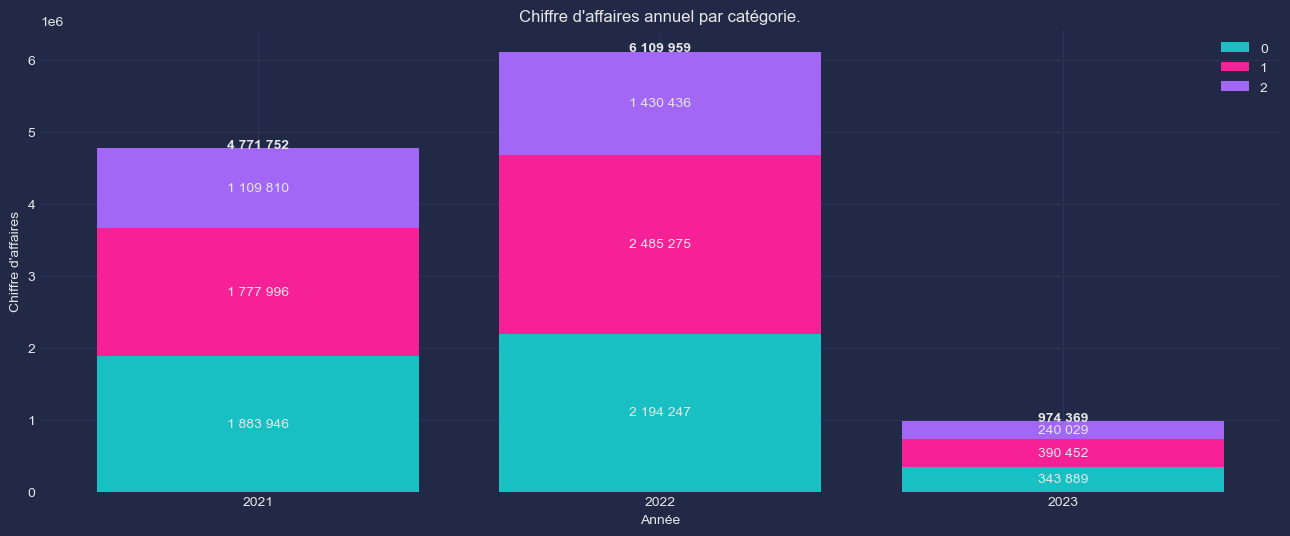

In [55]:
# Resampling annuel et calcul de la somme pour chaque année.
df_YoY = tsdf.resample("Y").sum().copy()

# Conversion de l'index en format de chaîne de caractères "YYYY".
df_YoY.index = pd.to_datetime(df_YoY.index, format="%Y").strftime("%Y")

# Ajout d'une colonne "Total" contenant la somme des valeurs de chaque ligne.
df_YoY["Total"] = df_YoY.sum(axis=1)

# Création d'un graphique à barres empilées pour visualiser le chiffre d'affaires annuel par catégorie.
fig, ax = plt.subplots(figsize =(16,6))
bottom = np.zeros(len(df_YoY))

# Boucle pour dessiner les barres empilées et les étiquettes de barres centrées.
for i, col in enumerate(df_YoY.columns[[0,1,2]]):
  j = ax.bar(df_YoY.index, df_YoY[col].round(0),  bottom=bottom, label=col)
  bottom += np.array(df_YoY[col])
  ax.bar_label(j, label_type='center', labels=df_YoY[col].apply(lambda x: '{:,.0f}'.format(x).replace(',', ' ')).values)

# Boucle pour ajouter des étiquettes de texte en haut de chaque pile de barres pour les totaux de chaque année.
for i, total in enumerate(df_YoY["Total"]):
  ax.text(df_YoY.index[i], total , '{:,.0f}'.format(round(total)).replace(',', ' '), ha="center", weight="bold")

# Ajout d'un titre, des étiquettes d'axes et une légende au graphique.
ax.set_title("Chiffre d'affaires annuel par catégorie.")
ax.set_xlabel('Année')
ax.set_ylabel("Chiffre d'affaires")
plt.legend(loc='best')
plt.show()

###  2.2.2 CA journalier

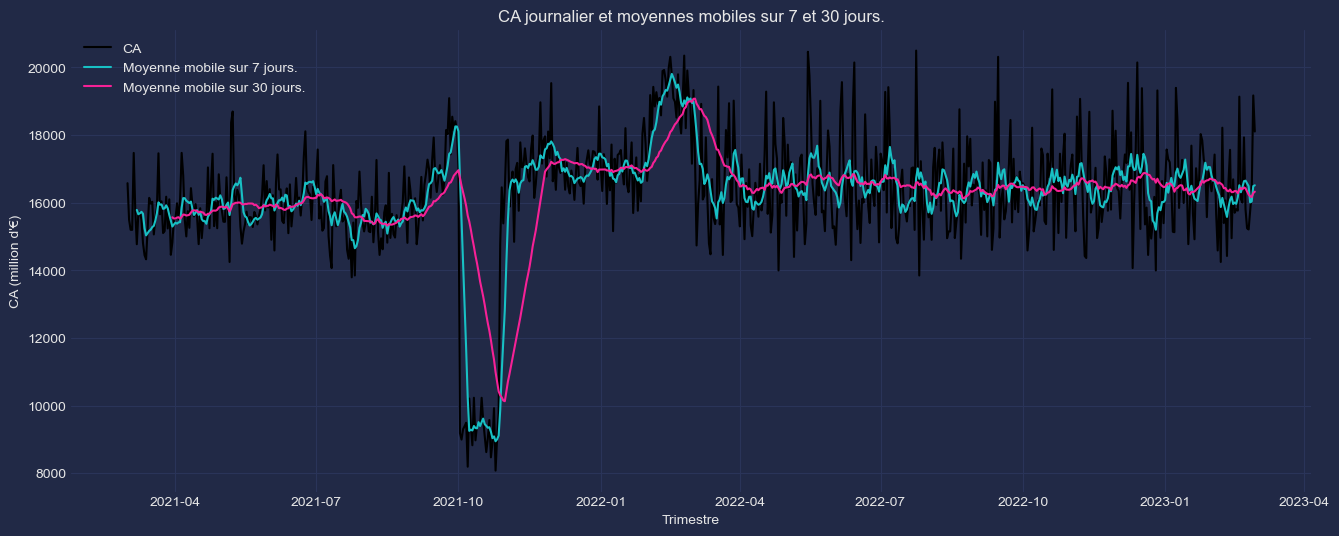

In [56]:
# Création d'un DataFrame pour la visualisation du chiffre d'affaires journalier.

# Agrégation des données par jour, ajout d'une colonne pour le total et création d'une copie du DataFrame.
df_DoD = tsdf.resample("D").sum().copy()

# Conversion de l'index en format de date.
df_DoD.index = pd.to_datetime(df_DoD.index, format="%d/%m/%Y")

# Ajout d'une colonne pour le total du chiffre d'affaires journalier.
df_DoD["Total"] = df_DoD.sum(axis=1)

# Visualisation du chiffre d'affaires journalier et décomposition en moyennes mobiles à 7 et 30 jours.

# Définition de la taille de la figure du graphique.
plt.figure(figsize=(16, 6))

# Traçage de la ligne pour le chiffre d'affaires journalier.
plt.plot(df_DoD["Total"], label="CA", color="black")

# Traçage de la ligne pour la moyenne mobile sur 7 jours.
plt.plot(df_DoD["Total"].rolling(7).mean(), label="Moyenne mobile sur 7 jours.")

# Traçage de la ligne pour la moyenne mobile sur 30 jours.
plt.plot(df_DoD["Total"].rolling(30).mean(), label="Moyenne mobile sur 30 jours.")

plt.title("CA journalier et moyennes mobiles sur 7 et 30 jours.")

plt.xlabel("Trimestre")

# Définition du label de l'axe y du graphique.
plt.ylabel("CA (million d'€)")

# Ajout d'une légende pour le graphique.
plt.legend(loc="best")

# Affichage du graphique.
plt.show()


La décomposition en moyenne mobile nous permet de mieux appréhender les fluctuations à court terme et les événements aléatoires.

###  2.2.3 CA mensuel

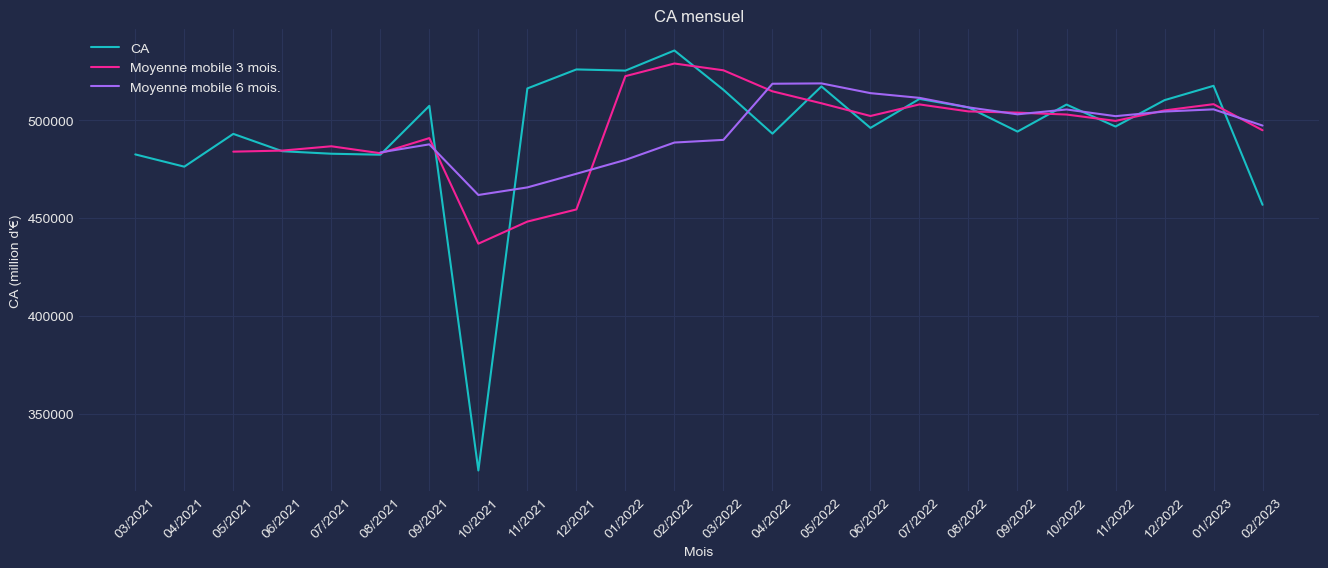

In [57]:
# Création d'un DataFrame pour la visualisation du chiffre d'affaires mensuel.

# Agrégation des données par mois, ajout d'une colonne pour le total et création d'une copie du DataFrame.
df_MoM = tsdf.resample("M").sum().copy()

# Conversion de l'index en format de date et en format mois/année.
df_MoM.index = pd.to_datetime(df_MoM.index, format="%m/%Y").strftime("%m/%Y")

# Ajout d'une colonne pour le total du chiffre d'affaires mensuel.
df_MoM["Total"] = df_MoM.sum(axis=1)

# Visualisation du chiffre d'affaires mensuel et décomposition en moyennes mobiles à 3 et 6 mois.

# Définition de la taille de la figure du graphique.
plt.figure(figsize=(16, 6))

# Traçage de la ligne pour le chiffre d'affaires mensuel.
sns.lineplot(data=df_MoM["Total"], label="CA")

# Traçage de la ligne pour la moyenne mobile sur 3 mois.
plt.plot(df_MoM["Total"].rolling(3).mean(), label="Moyenne mobile 3 mois.")

# Traçage de la ligne pour la moyenne mobile sur 6 mois.
plt.plot(df_MoM["Total"].rolling(6).mean(), label="Moyenne mobile 6 mois.")

# Ajout d'une légende pour le graphique.
plt.legend(loc="best")

# Définition du titre, des labels de l'axe x et de l'axe y du graphique.
plt.title("CA mensuel")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.ylabel("CA (million d'€)")

# Affichage du graphique.
plt.show()


On peut observer ici une chute brutale du chiffre d'affaires en octobre 2021.

Ici, on peut voir que l'anomalie observée au mois d'Octobre 2021 n'a pas vraiment d'incidence sur le chiffre d'affaires global ou sur nos analyses.

Nous allons quand même faire un petit détour pour analyser ce mois de manière plus fine.

 ###  2.2.4 Évolution du chiffre d'affaires mensuel par catégorie

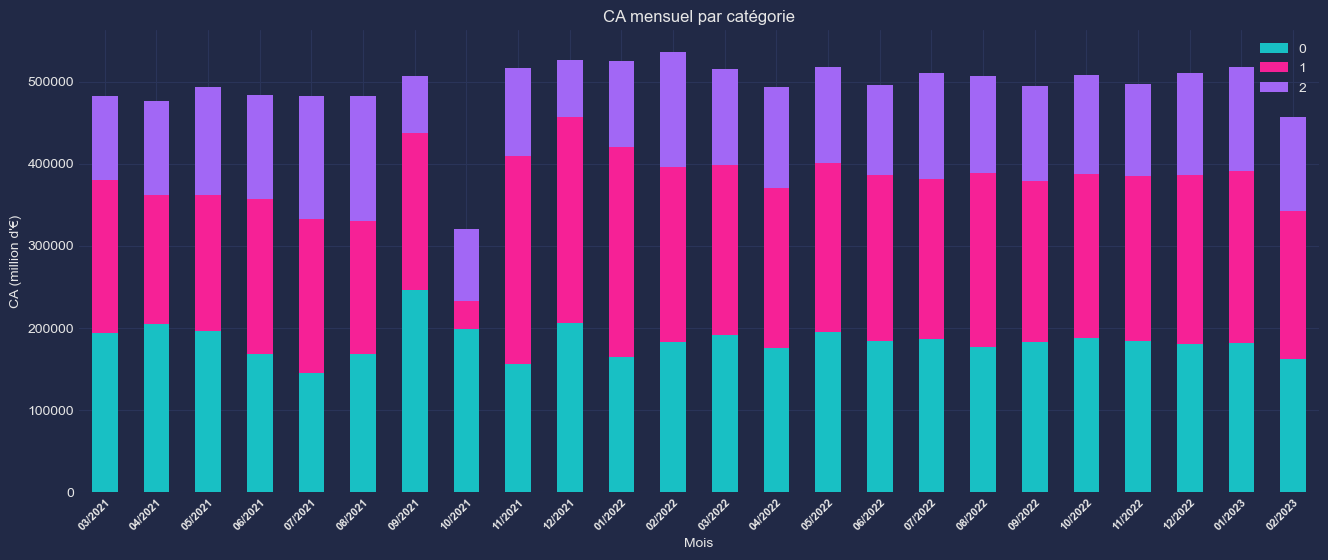

In [58]:
# Visualisation du chiffre d'affaires mensuel par catégorie.

# Création d'un graphique à barres empilées pour le chiffre d'affaires mensuel par catégorie.
ax = df_MoM.plot(y=[0, 1, 2], kind="bar", stacked=True, figsize=(16, 6))

# Définition du titre, des labels de l'axe x et de l'axe y du graphique.
plt.title("CA mensuel par catégorie")
plt.xlabel("Mois")
plt.ylabel("CA (million d'€)")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor', fontsize=8, fontweight='bold')

# Ajout d'une légende pour le graphique.
plt.legend(loc="best")

# Affichage du graphique.
plt.show()

###  2.2.5 Zoom sur le mois d'Octobre.

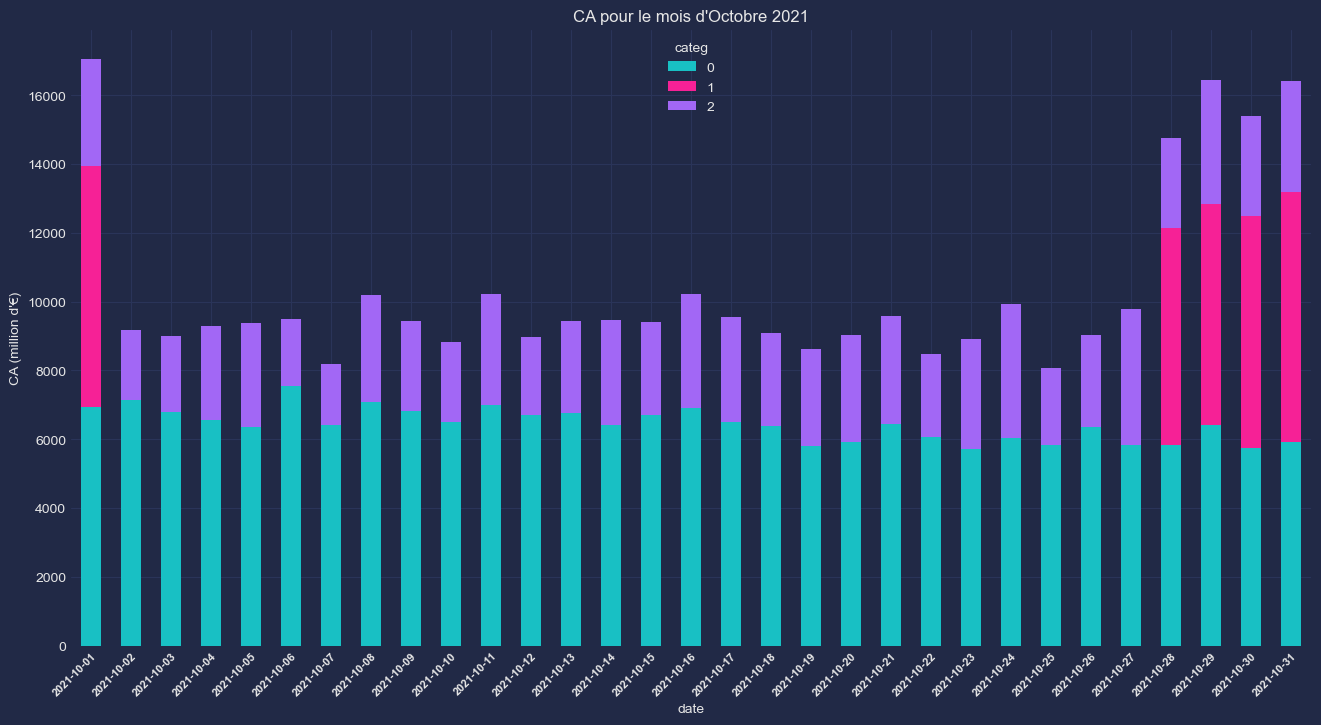

In [59]:
# Visualisation du chiffre d'affaires pour le mois d'Octobre 2021.
octobre = tsdf.resample("D").sum().loc["10/2021"]
# Agrégation des données par jour, sélection du mois d'octobre 2021 et création d'un graphique à barres empilées pour le chiffre d'affaires par catégorie.
octobre.plot(y=[0, 1, 2], kind='bar', stacked=True, figsize=(16, 8))

# Définition du titre et du label de l'axe y du graphique.
plt.title("CA pour le mois d'Octobre 2021")
plt.ylabel("CA (million d'€)")

# Mise en forme des labels de l'axe x pour afficher uniquement la date sans l'heure.
plt.xticks(range(len(octobre.index.date)), octobre.index.date, rotation=45, ha='right', rotation_mode='anchor', fontsize=8, fontweight='bold')

# Affichage du graphique.
plt.show()


On peut voir sur ce graphique qu'aucune vente de la catégorie 1 n'a été enregistrée entre le 2 Octobre 2021 et le 27 Octobre 2021. Il pourrait s'agir d'une erreur technique, mais nous ne disposons pas d'assez d'éléments pour nous prononcer.

##  2.3.    Analyse des références.

###  2.3.1.  Top 10 des références.

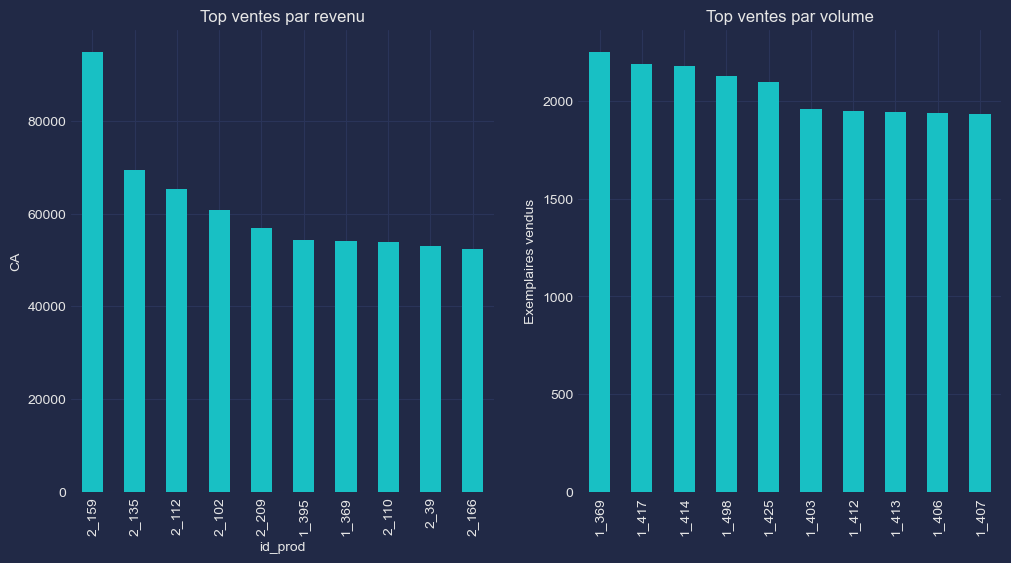

In [60]:
# Agrégation et calcul par revenu.
ref_revenu = df_central.groupby("id_prod")["price"].sum().nlargest(10)

# Agrégation et calcul par volume.
ref_volume = df_central["id_prod"].value_counts().nlargest(10)

# Visualisation du top 10 des références par revenu et par volume.

# Définit la taille de la figure du graphique.
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Création du premier graphique à barres pour le top 10 des ventes par revenu.
ref_revenu.plot(kind="bar", ax=axes[0], title="Top ventes par revenu")
axes[0].set_ylabel("CA")

# Création du deuxième graphique à barres pour le top 10 des ventes par volume.
ref_volume.plot(kind="bar", ax=axes[1], title="Top ventes par volume")
axes[1].set_ylabel("Exemplaires vendus")

# Affichage du graphique.
plt.show()


###  2.3.2. 10 références les moins vendues.

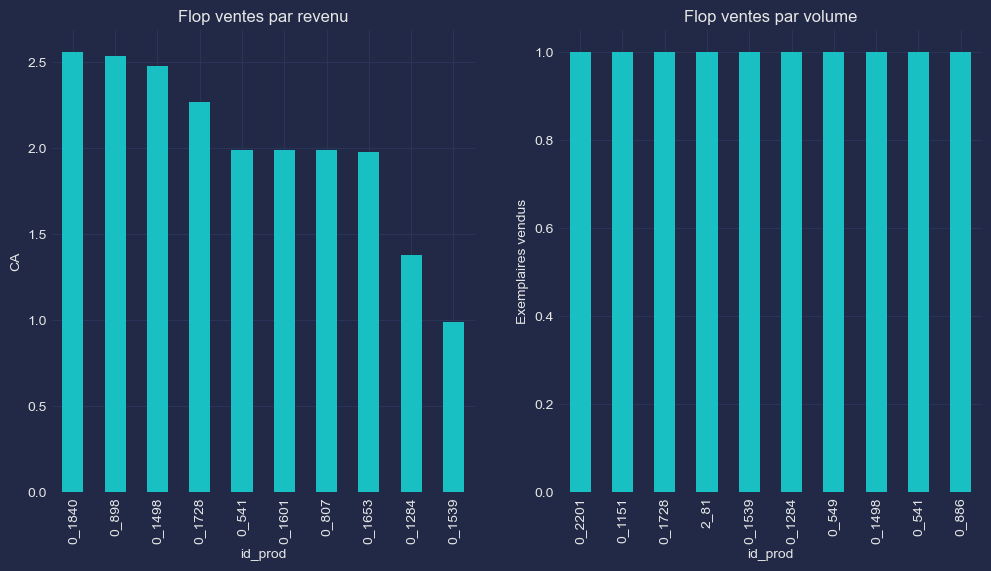

In [61]:
# Visualisation des 10 références les moins vendues par revenu et par volume.

# Agrégation et calcul par revenu.
ref_revenu = df_central.groupby("id_prod")["price"].sum().sort_values(ascending=False)

# Agrégation et calcul par volume.
ref_volume = df_central.groupby("id_prod")["id_prod"].count().sort_values(ascending=False)

# Création d'un graphique pour visualiser les 10 références les moins vendues par revenu et par volume.

# Définition de la taille de la figure du graphique.
plt.figure(figsize=(12, 6))

# Affichage du premier graphique à barres pour les 10 références les moins vendues par revenu.
plt.subplot(1, 2, 1)
ref_revenu.tail(10).plot(kind="bar", title="Flop ventes par revenu")
plt.ylabel("CA")

# Affichage du deuxième graphique à barres pour les 10 références les moins vendues par volume.
plt.subplot(1, 2, 2)
ref_volume.tail(10).plot(kind="bar", title="Flop ventes par volume")
plt.ylabel("Exemplaires vendus")

# Affichage du graphique.
plt.show()

### 2.3.3. Répartition des ventes par catégorie.

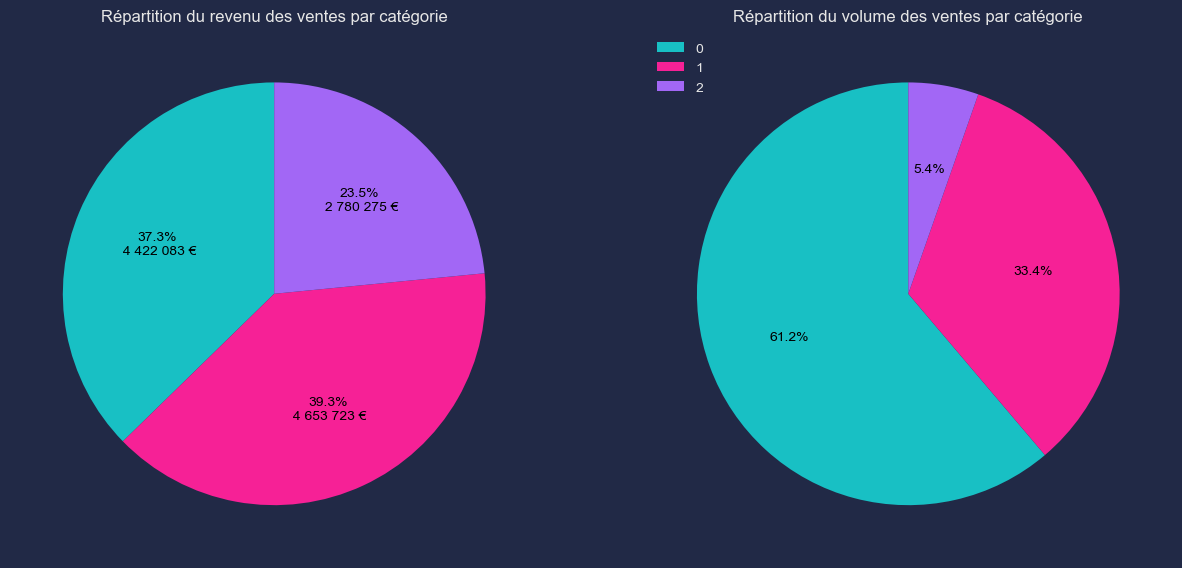

,categ,id_prod,price
0,0,415680,4422082.41
1,1,227169,4653722.69
2,2,36483,2780275.02


In [62]:
# Agrégation des données par catégorie et calcul du nombre d'exemplaires vendus et du chiffre d'affaires par catégorie
ax = df_central.groupby(["categ"]).agg({'id_prod': 'count', 'price': 'sum'}).reset_index()

# Définition de fonctions lambda pour la création des pourcentages d'autopct
autopct_revenue = lambda p: autopct_format(p, ax, 'price')

# Définition de la taille de la figure et création des deux sous-graphiques en une ligne et deux colonnes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Création du premier graphique à secteurs pour la répartition du revenu des ventes par catégorie
ax1.pie(ax['price'], autopct=autopct_revenue, startangle=90, labels=None, textprops=dict(color="black"))
ax1.set_title("Répartition du revenu des ventes par catégorie")

# Création du deuxième graphique à secteurs pour la répartition du volume des ventes par catégorie
ax2.pie(ax['id_prod'], startangle=90, autopct='%1.1f%%', textprops=dict(color="black"))
ax2.set_title("Répartition du volume des ventes par catégorie")
                            
# Ajout d'une légende pour les deux graphiques
plt.legend(ax['categ'], loc='upper left')

# Affichage des graphiques
plt.show()
ax

### 2.3.3.  Analyse univariée de la variable prix catégorie par catégorie.

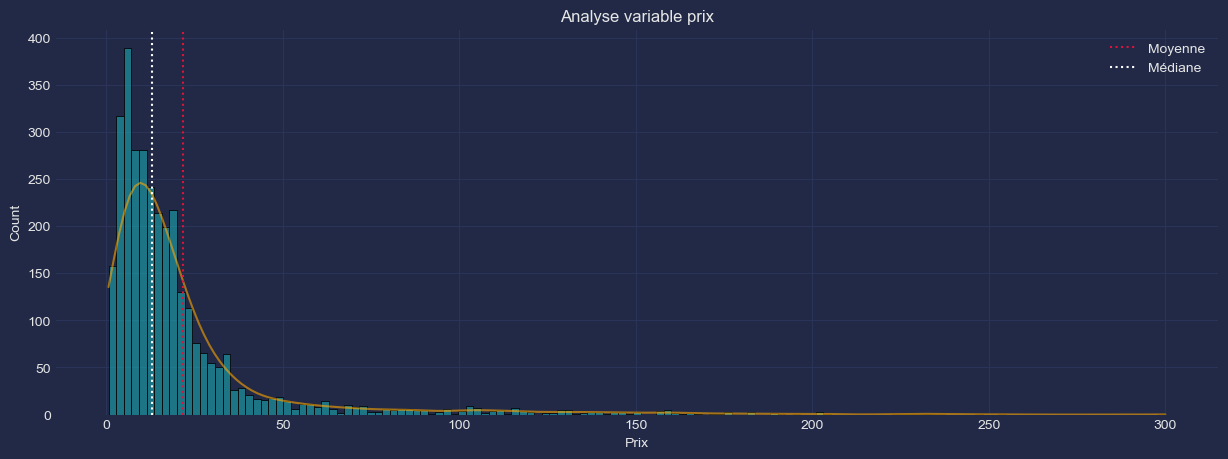

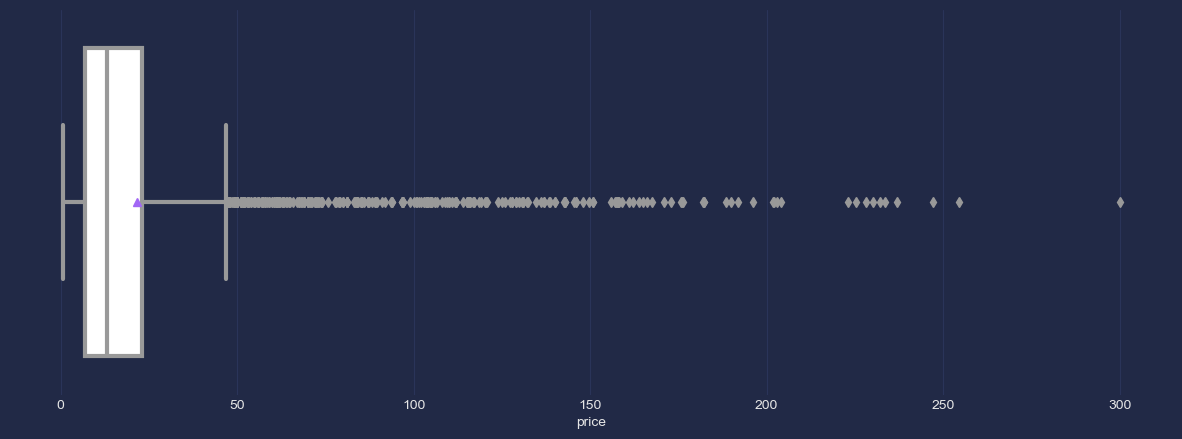

╒════╤════════════════╤══════════╕
│    │ Statistiques   │   Valeur │
╞════╪════════════════╪══════════╡
│  0 │ Moyenne        │    21.76 │
├────┼────────────────┼──────────┤
│  1 │ Médiane        │    13.04 │
├────┼────────────────┼──────────┤
│  2 │ Mode           │     4.99 │
├────┼────────────────┼──────────┤
│  3 │ Variance       │   875.21 │
├────┼────────────────┼──────────┤
│  4 │ Ecart-type     │    29.58 │
╘════╧════════════════╧══════════╛


In [63]:
# Analyse de la variable "price" dans le DataFrame "df_central".

# Création d'un nouveau DataFrame "prix" qui contient une seule occurrence de chaque produit dans la colonne "id_prod".
prix = df_central.drop_duplicates(subset=["id_prod"])

# Calcul des statistiques descriptives de la variable "price" dans le DataFrame "prix".
moyenne = round(prix['price'].mean(), 2)
mediane = round(prix['price'].median(), 2)
mode = round(prix['price'].mode().to_dict()[0], 2)
variance = round(prix['price'].var(), 2)
ecart_type = round(prix['price'].std(), 2)

# Création d'un DataFrame pour stocker les statistiques descriptives.
df_stats = pd.DataFrame({
    'Statistiques': ['Moyenne', 'Médiane', 'Mode', 'Variance', 'Ecart-type'],
    'Valeur': [moyenne, mediane, mode, variance, ecart_type]
})

# Création d'une visualisation pour observer la distribution des prix.
plt.figure(figsize=(15,5))
ax = sns.histplot(prix["price"], kde=True)
ax.set(title="Analyse variable prix", xlabel="Prix")
ax.lines[0].set(color="orange", alpha=0.6)
ax.axvline(prix["price"].mean(), color="crimson", linestyle="dotted", label="Moyenne")    
plt.axvline(prix["price"].median(), color="white", linestyle="dotted", label="Médiane")
plt.legend()
plt.show()

# Création d'une visualisation pour observer la répartition des prix.
plt.figure(figsize=(15,5))
ax = sns.boxplot(x="price", data=prix, linewidth=3, color="white", showmeans=True)

plt.show()
# Affichage du tableau récapitulatif.
print(tabulate(df_stats, headers='keys', tablefmt='fancy_grid'))


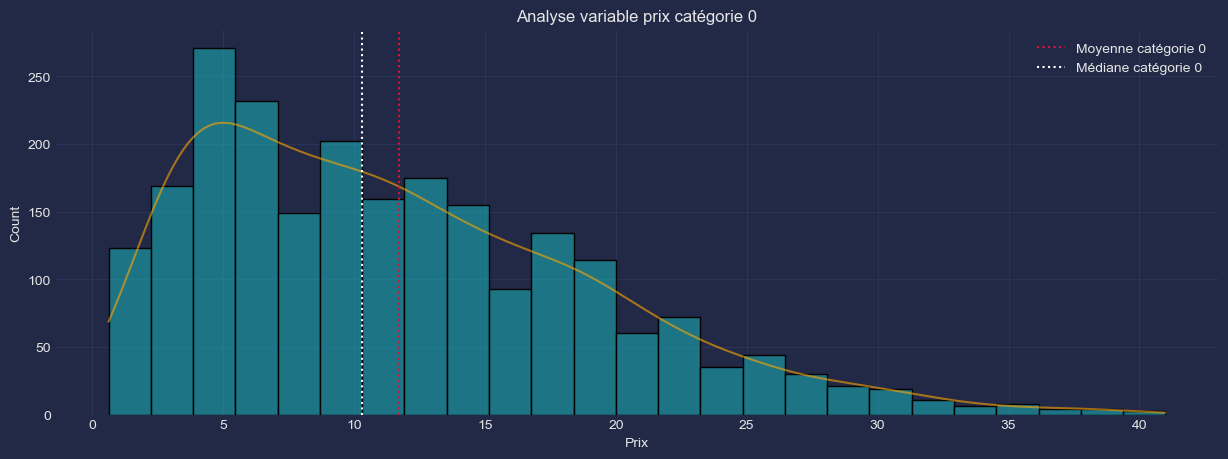

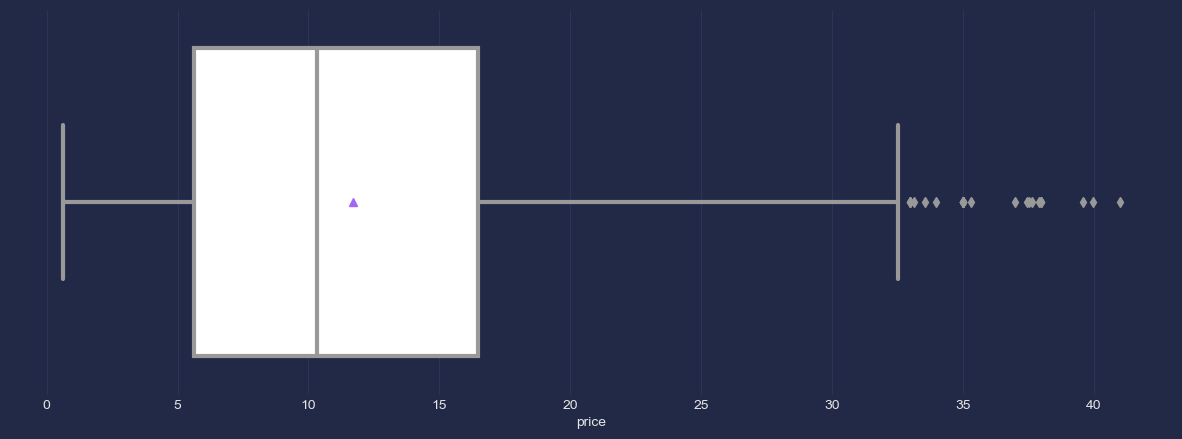

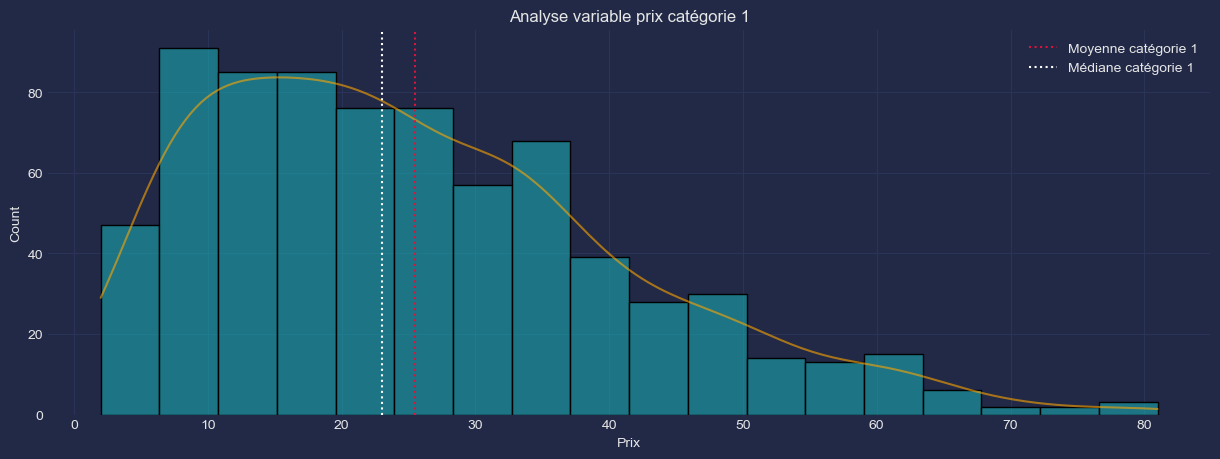

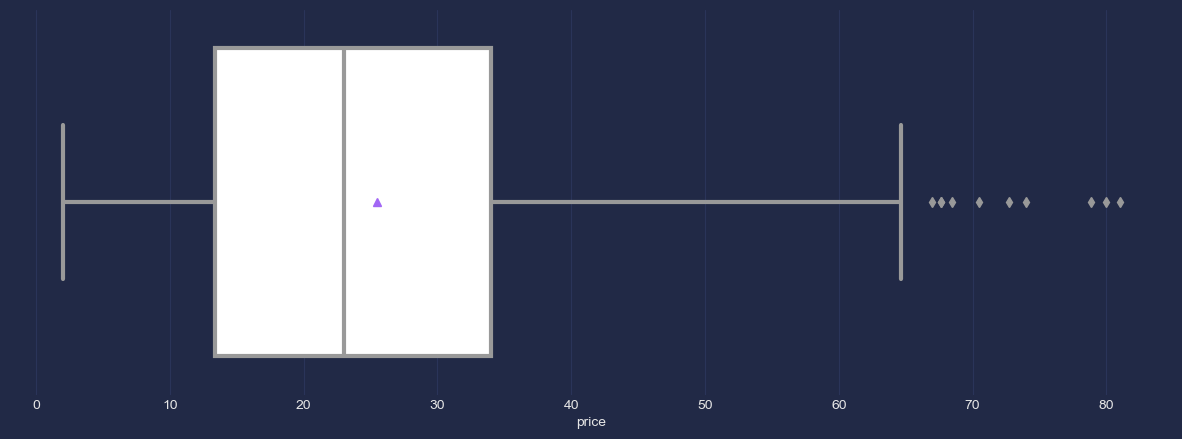

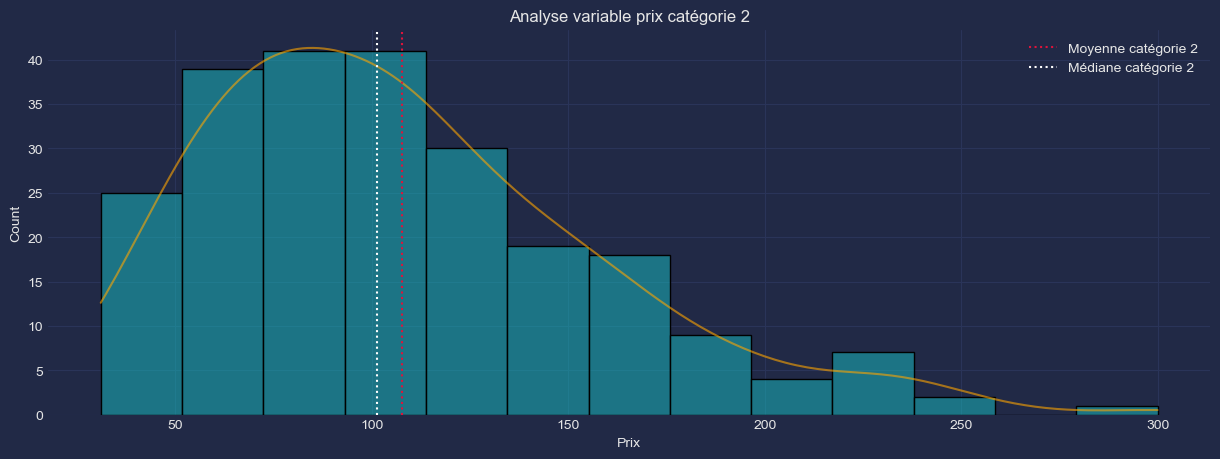

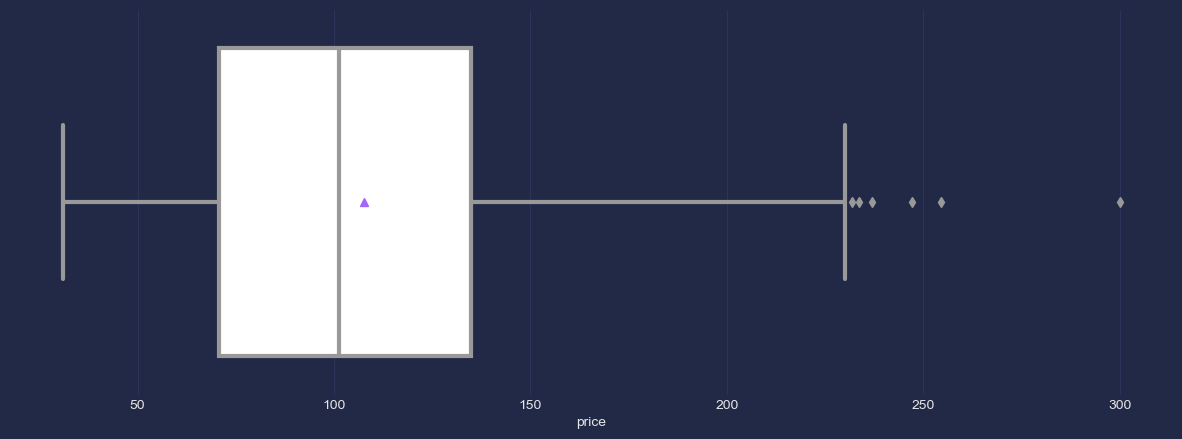

╒════╤═══════════╤═══════════╤════════╤═══════════╤═══════════╤════════════╤══════════════╕
│    │   Moyenne │   Médiane │   Mode │   Minimum │   Maximum │   Variance │   Ecart-type │
╞════╪═══════════╪═══════════╪════════╪═══════════╪═══════════╪════════════╪══════════════╡
│  0 │     11.71 │     10.32 │   4.99 │      0.62 │     40.99 │      56.68 │         7.53 │
├────┼───────────┼───────────┼────────┼───────────┼───────────┼────────────┼──────────────┤
│  1 │     25.5  │     22.99 │  22.99 │      2    │     80.99 │     238.25 │        15.44 │
├────┼───────────┼───────────┼────────┼───────────┼───────────┼────────────┼──────────────┤
│  2 │    107.64 │    101.25 │  50.99 │     30.99 │    300    │    2426.11 │        49.26 │
╘════╧═══════════╧═══════════╧════════╧═══════════╧═══════════╧════════════╧══════════════╛


In [64]:
pa = AnalysePrix(df_central)
pa.analyser_par_categorie()

##  2.4.	Analyse du profil des clients.

In [65]:
# Ajout d'une colonne âge.
df_central["Age"] = (df_central["date"].dt.year - df_central["birth"]).astype(int)

### 2.4.1.  Top 10 clients.

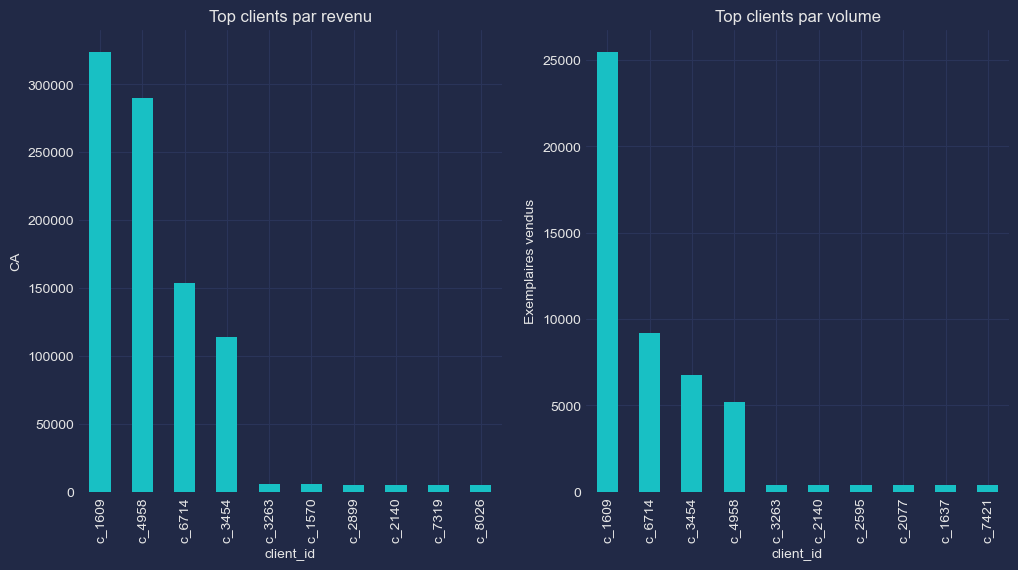

In [66]:
# Calcul du top 10 des clients par revenu.
top_clientsca = df_central.groupby("client_id")["price"].apply("sum").sort_values(ascending=False).head(10)
# Calcul du top 10 des clients par volume.
top_clientsvol = df_central.groupby("client_id")["session_id"].apply("count").sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))

# Visualisation du top 10 des clients par revenu.
plt.subplot(1, 2, 1)
top_clientsca.plot(kind="bar", title="Top clients par revenu")
plt.ylabel("CA")

# Visualisation du top 10 des clients par volume.
plt.subplot(1, 2, 2)
top_clientsvol.plot(kind="bar", title="Top clients par volume")

plt.ylabel("Exemplaires vendus")

plt.show()

On peut voir quatre clients qui se démarquent du lot par un volume d'achat beaucoup plus important que le reste de la clientèle, nous allons faire une analyse rapide de ces quatre clients et de leurs habitudes d'achat pour voir comment les traiter par la suite.

In [67]:
# Création d'une variable contenant la liste des clients outliers.
liste = ["c_4958", "c_3454", "c_6714", "c_1609"]

In [68]:
# Création d'un DataFrame pour l'analyse des clients outliers.
df_pro = (
    df_central
    # Filtrage à l'aide de la liste créée précédemment.
    .query("client_id == @liste")
    # Ajout des colonnes utiles.
    [["client_id", "price", "session_id", "id_prod"]]
    # Groupage par identifiant.
    .groupby(["client_id"])
    # Agrégation et renommage des colonnes.
    .agg(nombre_achats=("session_id", "count"), CA=("price", "sum"), nombre_references=("id_prod", pd.Series.nunique))
    .copy()
)
df_pro


,nombre_achats,CA,nombre_references
client_id,,,
c_1609,25488,324033.35,1920
c_3454,6773,113669.85,1094
c_4958,5195,289760.34,467
c_6714,9187,153662.76,1381


Au vu du nombre d'achats, du montant des achats et du nombre de références commandées, nous avons ici affaire à 4 clients professionnels.
Nous allons donc les supprimer pour le reste de nos analyses démographiques et pour l'étude des corrélations.

In [69]:
# Création d'un DataFrame contenant uniquement les clients particuliers.
df_particuliers = (
    df_central
    .query("client_id != @liste")  # Filtrage des clients professionnels à l'aide de la liste "liste".
    [["client_id", "sex", "Age", "price", "session_id"]]  # Sélection des colonnes nécessaires.
    .groupby(["client_id"])  # Regroupement des données par client_id.
    .agg(  # Agrégation des données pour chaque groupe.
        sex=("sex", "first"),  # Première valeur rencontrée pour "sex".
        Age=("Age", lambda x: int(x.median())),  # Médiane de "Age" arrondie à l'entier inférieur.
        nombre_achats=("session_id", "count"),  # Comptage du nombre de "session_id" pour chaque groupe.
        CA=("price", "sum")  # Somme des "price" pour chaque groupe.
    )
    .copy()  # Copie du DataFrame obtenu pour éviter toute modification accidentelle du DataFrame original.
)

df_particuliers.head()

,sex,Age,nombre_achats,CA
client_id,,,,
c_1,m,67,39,558.18
c_10,m,66,58,1353.60
c_100,m,29,8,254.85
c_1000,f,56,125,2261.89
c_1001,m,40,102,1812.86


### 2.4.2.  Visualisation de la distribution des âges par genre à l'aide d'une pyramide des âges

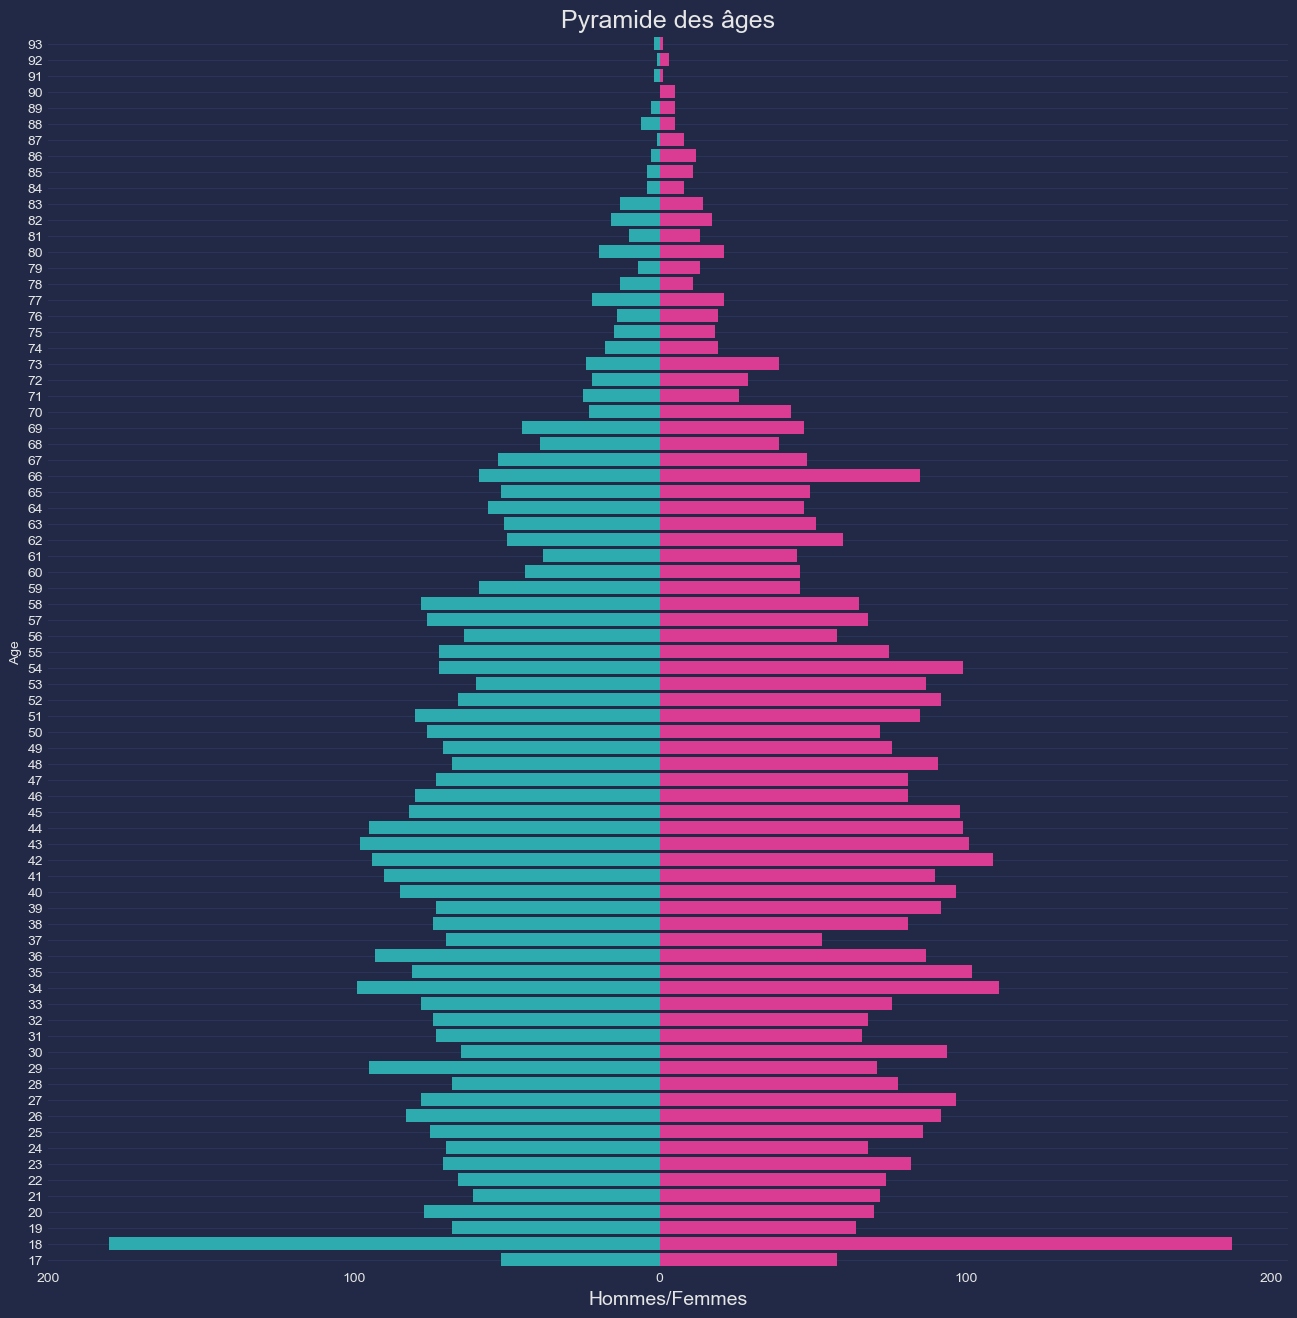

In [70]:
# Création d'un tableau croisé dynamique (crosstab) à partir des colonnes "Age" et "sex" du DataFrame "df_particuliers".
pyramide = pd.crosstab(df_particuliers["Age"], df_particuliers["sex"])

# Multiplication des valeurs de la colonne "m" par -1 pour inverser la direction des barres pour les hommes.
pyramide["m"] = pyramide["m"] * -1

plt.figure(figsize=(16, 16))

# Création d'un barplot pour les hommes (colonne "m") avec une couleur spécifique.
ax1 = sns.barplot(x="m", y=pyramide.index, data=pyramide, orient="h", color="#18c0c4")

# Création d'un barplot pour les femmes (colonne "f") avec une couleur spécifique.
ax2 = sns.barplot(x="f", y=pyramide.index, data=pyramide, orient="h", color="#f62196")

# Personnalisation des étiquettes des graduations de l'axe x pour refléter les valeurs positives et négatives.
plt.xticks(ticks=[-200, -100, 0, 100, 200], labels=["200", "100", "0", "100", "200"])

# Ajout un titre au graphique.
plt.title("Pyramide des âges", fontsize=18)

# Ajout une étiquette pour l'axe x.
plt.xlabel("Hommes/Femmes" , fontsize=14)

# Inverse l'ordre des graduations de l'axe y pour afficher les âges de manière décroissante.
ax1.invert_yaxis()

# Ajout une grille pour faciliter la lecture du graphique.
plt.grid()
plt.show()


On observe une distribution assez égalitaire entre les hommes et les femmes.

Il y a une forte concentration de nos clients entre 25 et 50 ans.

On observe un pic important pour les clients de 18 ans, il pourra s'agir ici de clients mineurs qui s'enregistrent à cet âge.


### 2.4.3.  Visualisation  Visualisation de la répartition des clients par genre.

╒════╤═════════╤═════════════╕
│    │ Genre   │   Effectifs │
╞════╪═════════╪═════════════╡
│  0 │ f       │        4478 │
├────┼─────────┼─────────────┤
│  1 │ m       │        4118 │
╘════╧═════════╧═════════════╛


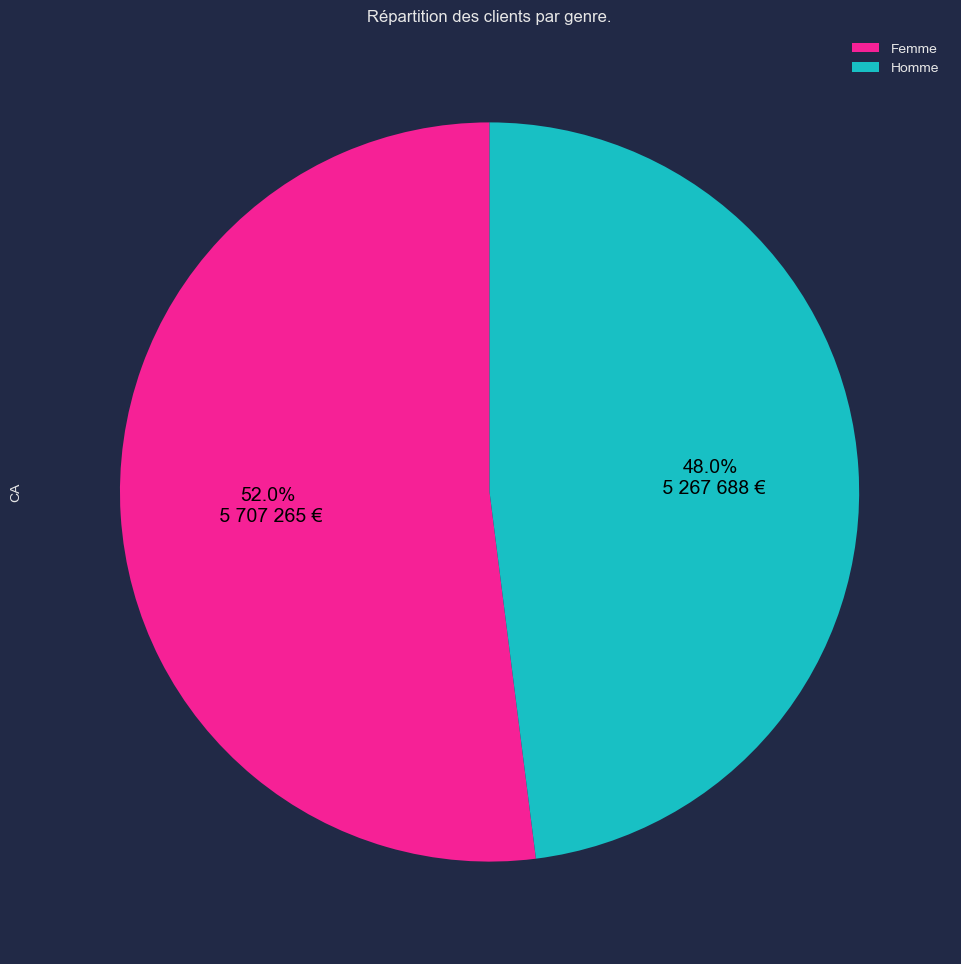

In [71]:
plt.figure(figsize=(12,12))
# Utilisation de la fonction autopct_format
df_sex = df_particuliers.groupby(["sex"])["CA"].sum().reset_index()
autopct_genre = lambda p: autopct_format(p, df_sex, 'CA')

df_sex["CA"].plot.pie(y='CA',autopct=autopct_genre, startangle=90, fontsize=14, colors=['#f62196', '#18c0c4'], labels=None, textprops=dict(color="black"))
plt.title("Répartition des clients par genre.")
plt.legend(loc='upper right', labels=['Femme', 'Homme'])
# Calcul du nombre de clients par catégorie sexuelle
df_effectifs = df_particuliers["sex"].value_counts().reset_index()

# Renommage des colonnes pour le tableau
df_effectifs.columns = ["Genre", "Effectifs"]

# Affichage du tableau
print(tabulate(df_effectifs, headers='keys', tablefmt='fancy_grid'))

plt.show()

### 2.4.4. Répartition du chiffre d'affaires entre les clients.

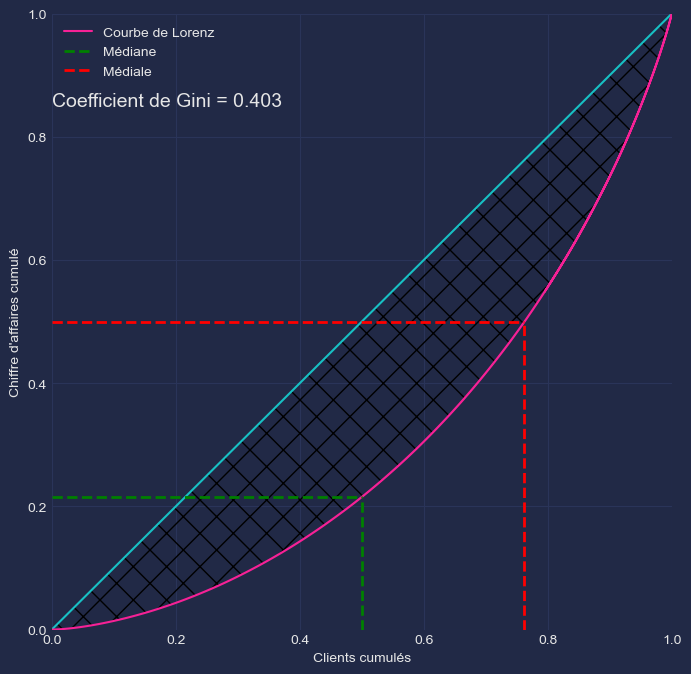

In [72]:
dep = df_particuliers["CA"].values
n = len(dep)

# Calcul de la courbe de Lorenz pour la distribution des valeurs de "dep" et stocker la somme cumulative des valeurs triées dans la variable "lorenz".
lorenz = np.cumsum(np.sort(dep)) / dep.sum()

# Création d'un ensemble de valeurs x de 0 à 1 ayant la même longueur que "lorenz" et les stocker dans la variable "xaxis".
xaxis = np.linspace(0, 1, len(lorenz))

# Calcul de l'aire sous la courbe de Lorenz et du coefficient de Gini.
asc = (lorenz.sum() - lorenz[-1] / 2 - lorenz[0] / 2) / n
S = 0.5 - asc  # aire entre la première bissectrice et la courbe de Lorenz.
gini = 2 * S

# Trouver la position de la médiane et la valeur de la médiane dans "dep".
pos_mediane = int(n / 2)
val_mediane = np.sort(dep)[pos_mediane]

# Trouver la position de la médiale et la valeur de la médiale dans "dep".
pos_mediale = np.where(lorenz >= 0.5)[0][0]
val_mediale = np.sort(dep)[pos_mediale]

# Création d' une figure pour le graphique.
plt.figure(figsize=(8, 8))

# Définition des limites et des libellés de l'axe x.
plt.xlim(0, 1)
plt.xlabel("Clients cumulés")

# Définition des limites et des libellés de l'axe y.
plt.ylim(0, 1)
plt.ylabel("Chiffre d'affaires cumulé")

# Trace la première bissectrice (ligne d'égalité parfaite).
plt.plot([0, 1], [0, 1])

# Remplissage de l'aire entre la courbe de Lorenz et la première bissectrice.
plt.fill_between(xaxis, xaxis, lorenz, alpha=0.001, hatch="x")

# Trace la courbe de Lorenz.
plt.plot(xaxis, lorenz, drawstyle="steps-post", label="Courbe de Lorenz")

# Trace les lignes pointillées vertes pour la médiane.
plt.plot([pos_mediane / n, pos_mediane / n], [0, lorenz[pos_mediane]], color="green", linestyle="--", linewidth=2, label="Médiane")
plt.plot([0, pos_mediane / n], [lorenz[pos_mediane], lorenz[pos_mediane]], color="green", linestyle="--", linewidth=2)

# Trace les lignes pointillées rouges pour la médiale.
plt.plot([0, pos_mediale / n], [lorenz[pos_mediale], lorenz[pos_mediale]], color="red", linestyle="--", linewidth=2, label="Médiale")
plt.plot([pos_mediale/n, pos_mediale/n], [0, lorenz[pos_mediale]], color="red", linestyle="--", linewidth=2)

# Affichage du coefficient de Gini dans le graphique.
plt.text(0, 0.85, "Coefficient de Gini = {:.3f}".format(gini), fontsize=14)

plt.legend()
plt.show()

L'indice de Gini est assez égalitaire : 
- 50% des clients font 20% du chiffre d'affaires.
- 50 pourcent du chiffre d'affaires est réalisé par 80% des clients.


# 3. Corrélations

In [73]:
# Création d'un DataFrame sans les clients professionnels par agrégation et filtrage pour l'analyse de corrélations. 
df_corr = df_central.query("client_id != @liste").copy()
# Création d'une nouvelle colonne "tranche" pour la discrétrisation des âges des clients.
df_corr["tranche"] = pd.cut(df_corr["Age"], bins=[16, 29, 49, 100], labels = ["17 - 29 ans","30 - 49 ans","50 - plus"])
df_particuliers["tranche"] = pd.cut(df_particuliers["Age"], bins=[16, 29, 49, 100], labels = ["17 - 29 ans","30 - 49 ans","50 - plus"]).copy()

## 3.1. Corrélation entre le genre et les catégories de livres achetés

Question : y a-t-il un lien entre le genre du client et la catégorie de livres achetés ?

Afin d'émettre une hypothèse de travail nous allons visualiser le nombre de ventes par catégorie et par genre.

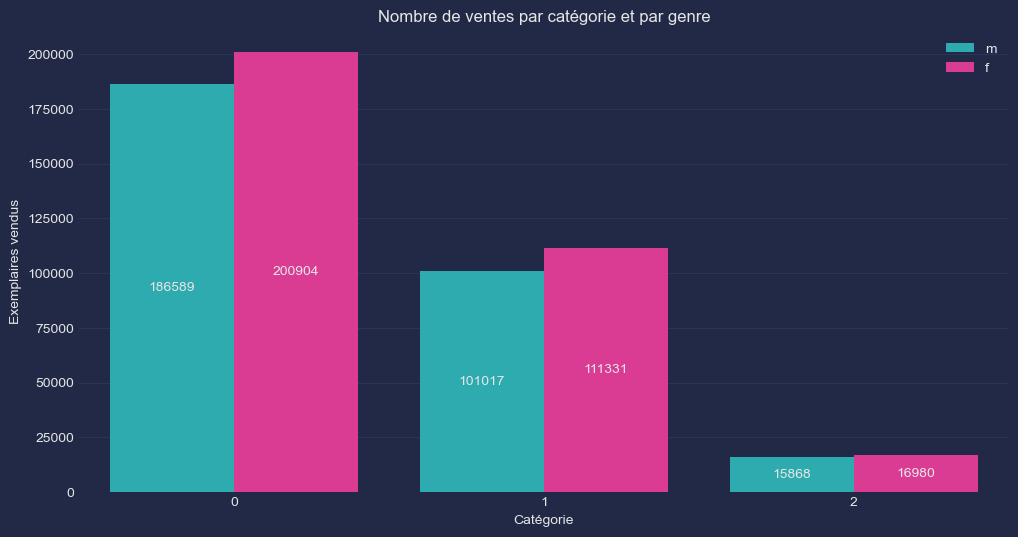

In [74]:
plt.figure(figsize=(12,6))

ax = sns.countplot(x="categ", hue="sex", data=df_corr, hue_order=["m", "f"])

for i in ax.containers:
    ax.bar_label(i, label_type="center")

ax.set_xlabel("Catégorie")
ax.set_ylabel("Exemplaires vendus")
ax.set_title("Nombre de ventes par catégorie et par genre")


plt.legend()
plt.show()

Nous pouvons voir dans les 3 catégories que les femmes achètent plus que des hommes, néanmoins les proportions semblent être proches les unes des autres.

- **$H_0$** : la catégorie de livres achetés ne dépend pas du genre du client. Les variables **Genre** et **Catégorie** sont **indépendantes**.

- **$H_1$** : les 2 variables **Genre** et **Catégorie** **sont liées.**



#### Nous sommes ici en présence de 2 variables qualitatives : nous allons donc procéder à un test d'indépendance du **$Chi-2$**.

Établissement d'un tableau de contingence pour croiser les modalités de nos variables : 

- **Catégorie** : variable dépendante placée en colonnes.
- **Genre** : placé en ligne c'est notre variable indépendante.

In [75]:
# Création d'un tableau de contingence pour les 2 colonnes concernées.
tableau = pd.crosstab(
                     df_corr["sex"],
                     df_corr["categ"],
                     margins=True,
                     margins_name="Total",
                     )
tableau

categ,0,1,2,Total
sex,,,,
f,200904,111331,16980,329215
m,186589,101017,15868,303474
Total,387493,212348,32848,632689


On obtient les effectifs observés **$O_{ij}$** dans chaque case, ainsi que les **sommes marginales** par colonnes et par lignes et les **effectifs totaux**.

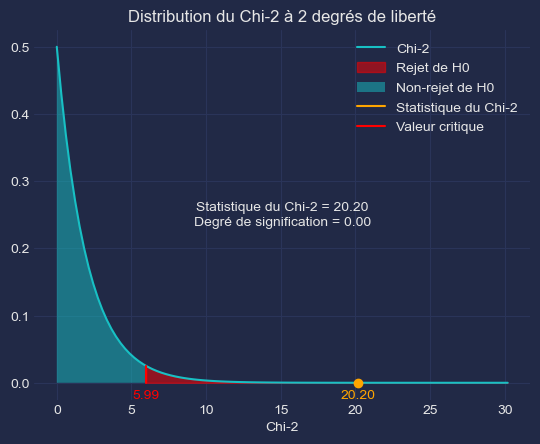

In [76]:
# Définition du risque standard
alpha = 0.05

# Calcul de la statistique du Chi-2, du degré de signification, du degré de liberté, et de la table des effectifs attendus Cij.
chi2, p, ddl, attendus = ss.chi2_contingency(tableau.iloc[:-1, :-1])

# Calcul de la valeur critique
crit = ss.chi2.ppf(1-alpha, ddl)

# Définition des valeurs des axes x et y
x = np.linspace(0, chi2+10, 100)
y = ss.chi2.pdf(x, ddl)


# Visualisation de la distribution du Chi-2 à 2 degrés de liberté
plt.plot(x, y, label='Chi-2')

# Coloration de la région de rejet
x_rejet = np.linspace(crit, x[-1], 100)
plt.fill_between(x_rejet, ss.chi2.pdf(x_rejet, ddl), color='red', alpha=0.5, label='Rejet de H0')

# Coloration de la région de non-rejet
x_nonrejet = np.linspace(x[0], crit, 100)
plt.fill_between(x_nonrejet, ss.chi2.pdf(x_nonrejet, ddl), alpha=0.5, label='Non-rejet de H0')

# Traçage de la statistique du test du Chi-2 calculée
plt.axvline(chi2, color='orange', linestyle='-', ymax=0, label='Statistique du Chi-2')
plt.text(chi2, -0.01, f'{chi2:.2f}', ha='center', va='top', color='orange')

# Traçage de la valeur critique
plt.plot([crit, crit], [0, ss.chi2.pdf(crit, ddl)], color='red', linestyle='-', label='Valeur critique')
plt.scatter(chi2, 0, color='orange', marker='o', zorder=3)
plt.text(crit, -0.01, f'{crit:.2f}', ha='center', va='top', color='red')

# Définition du titre et des étiquettes des axes x et y
plt.title('Distribution du Chi-2 à 2 degrés de liberté')
plt.xlabel('Chi-2')

# Affichage de la statistique du test du Chi-2 et du degré de signification
plt.text(max(x)/2, max(y)/2, f'Statistique du Chi-2 = {chi2:.2f}\nDegré de signification = {p:.2f}', ha='center', va='center')

# Affichage de la légende
plt.legend()
plt.show()

Étant donné que le Chi-2 calculé est supérieur au Chi-2 seuil pour un risque Alpha a 5% ou que la pvalue est inférieure à 5 pourcent : **$H_0$** est rejetée.

Il y a un lien entre le genre des clients et les catégories de livres achetés.


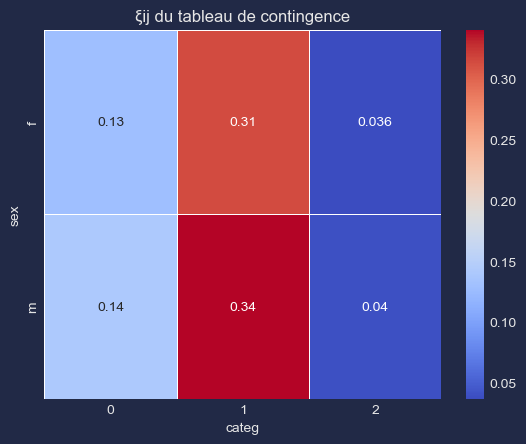

In [77]:
# tableau des effectifs calculés Cij
tableau_calc = pd.DataFrame(attendus, index=tableau.index[:-1], columns=tableau.columns[:-1])

# Calcule les contributions (ξij) au chi-carré en soustrayant les valeurs attendues des valeurs observées, élevant le résultat au carré et divisant par les valeurs attendues.
contribution = (tableau.iloc[:-1, :-1] - attendus)**2 / attendus

# Normalise les contributions par la valeur du chi-carré pour obtenir un tableau de contributions normalisées.
tableau_contribution = contribution / chi2

# Crée une heatmap pour visualiser les contributions normalisées (ξij) en utilisant Seaborn.
sns.heatmap(tableau_contribution, annot=True, linewidths=.5, cmap="coolwarm")

# Ajoute un titre à la heatmap.
plt.title("ξij du tableau de contingence")

# Affiche la heatmap.
plt.show()



Les différences entre les valeurs observées et les valeurs calculées sont le plus importants au sein de la catégorie 1


## 3.2. Corrélation entre l’âge des clients 

### 3.2.1.	Et le montant total des achats

## Question : y a-t-il un lien entre l'âge des clients et le montant total des achats ? 

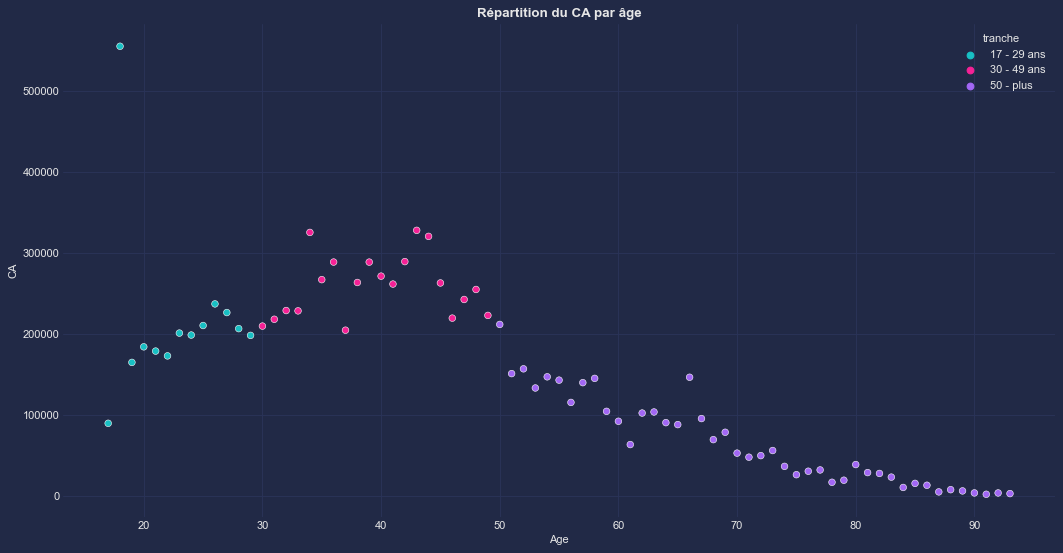

In [78]:
# Agrégation du montant total des achats par âge.
df_particuliers= df_particuliers.groupby("Age").agg({"CA":"sum", "tranche": "first"}).reset_index()

#scatter plot
fig = plt.figure(num=None, figsize=(16,8), dpi=80)
sns.scatterplot( x= df_particuliers["Age"],y = df_particuliers["CA"], hue= df_particuliers["tranche"])
plt.title("Répartition du CA par âge",fontsize = 12, fontweight='bold')
plt.show()

On peut tout d'abord voir une valeur qui se dégage du lot, en effet le montant total des achats pour les clients de 18 ans représente ici un outlier que nous allons supprimer.

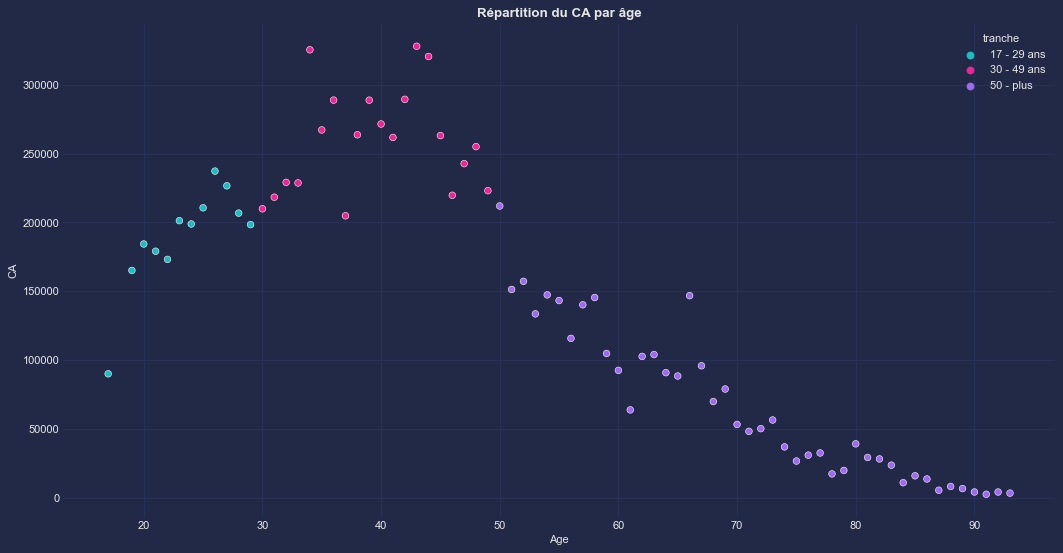

In [79]:
# Création d'un nouveau DataFrame sans les clients de 18 ans
df_particuliers = df_particuliers.query("Age != 18").copy()
fig = plt.figure(num=None, figsize=(16,8), dpi=80)
sns.scatterplot( x= df_particuliers["Age"],y = df_particuliers["CA"], hue= df_particuliers["tranche"])
plt.title("Répartition du CA par âge",fontsize = 12, fontweight='bold')
plt.show()

- **$H_0$** : Le montant total des achats ne dépend pas de l'âge des clients.

- **$H_1$** : Le montant total des achats dépend de l'âge des clients.

## Nous avons ici à faire à 2 variables quantitatives : nous allons donc voir si nous pouvons procéder à un test de corrélation de Pearson.

1. Relation linéaire : Les variables doivent être liées linéairement. 
2. Normalité : Les variables doivent être distribuées normalement: nous utiliserons un test de Kolmogorov-Smirnov.
3. Homoscédasticité : La variance des résidus doit être constante : nous utiliserons un test de Levene.


Résultat du test de normalité (Kolmogorov-Smirnov) pour la variable dependante : p-value = 0.10537354663284582
Résultat du test de normalité (Kolmogorov-Smirnov) pour la variable indépendante : p-value = 0.6701602137732526
Les deux variables suivent une distribution normale.


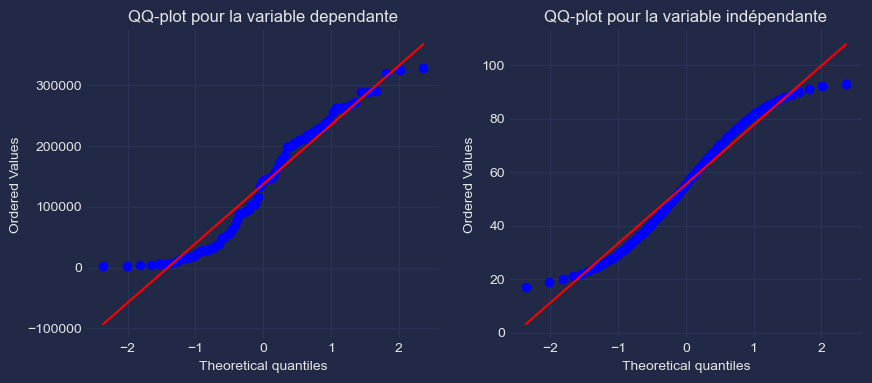

Résultat du test de Levene pour l'homoscédasticité : p-value = 1.8167983296308011e-34
Les résidus ont des variances différentes.
Les conditions pour utiliser la corrélation de Pearson ne sont pas remplies.


In [80]:
var_dep = df_particuliers["CA"]
var_indep = df_particuliers["Age"]

pearson_check = VerifCorrelationPearson(var_dep, var_indep)
peut_utiliser_pearson = pearson_check.peut_utiliser_pearson()


Puisque les conditions requises pour utiliser la corrélation de Pearson ne sont pas remplies, nous allons plutôt opter pour un test non paramétrique, tel que la corrélation de rang de Spearman.

La corrélation de Spearman évalue la relation entre deux variables continues ou ordinales sans supposer la normalité des données ni l'homoscédasticité des résidus.

Résultat du test de Spearman : corr = -0.84, p-value = 0.0000
Il n'y a pas de corrélation significative entre les deux variables.


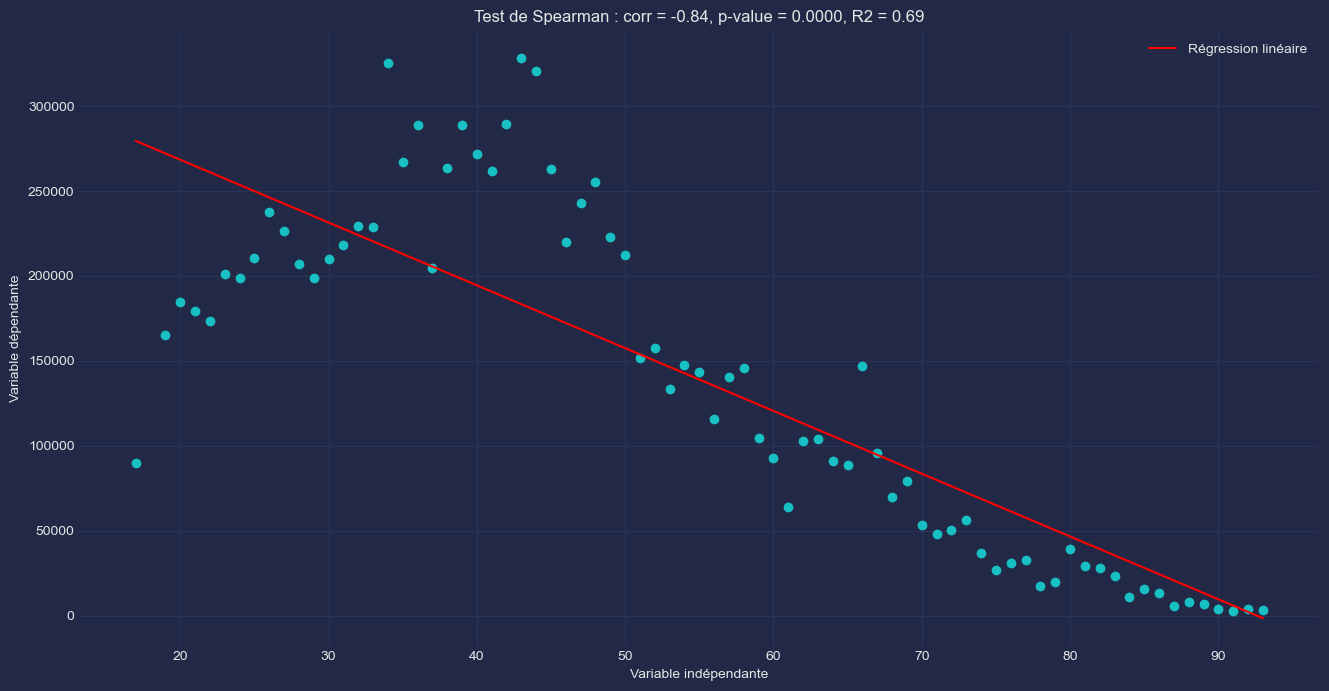

In [81]:
test_spearman(var_indep, var_dep)

Nous avons obtenu une droite de régression qui montre qu'il existe une composante linéaire dans la relation entre nos deux variables. Cependant, en observant la forme du graphique, il pourrait être plus pertinent de discrétiser la variable indépendante en catégories et de réaliser une analyse de variance (ANOVA) pour explorer davantage cette relation.

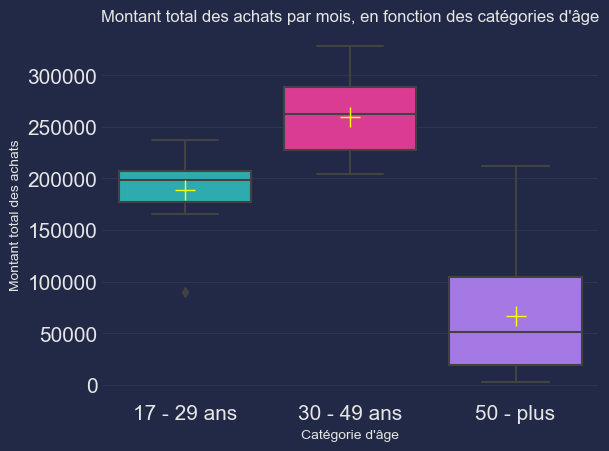

In [82]:
meanprops = {"marker": "+", "markeredgecolor": "yellow", "markersize": 15}

# Création d'une boîte à moustaches pour chaque tranche d'âge.
sns.boxplot(x=df_particuliers["tranche"], y=df_particuliers["CA"], showmeans=True, meanprops=meanprops)

# Ajout de titres et de labels pour les axes.
plt.title("Montant total des achats par mois, en fonction des catégories d'âge")
plt.ylabel("Montant total des achats")
plt.xlabel("Catégorie d'âge")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Affichage de la visualisation.
plt.show()

Nous pouvons voir une certaine disparité dans les moyennes des montants totaux des achats entre les différentes catégories d'âge, cette différence est-elle significative ? 

#### Nous sommes ici en présence d'une variable qualitative et d'une variable quantitative nous allons donc voir si nous pouvons procéder à une ANOVA. 

Pour réaliser une ANOVA, certaines conditions préalables doivent être respectées :

- Normalité des résidus de chaque groupe.
- Homoscédasticité des résidus.


Normalité des résidus pour 17 - 29 ans (variable dépendante: CA): p-valeur = 0.7509578128143304
Échec à rejeter l'hypothèse nulle: Les résidus pour 17 - 29 ans sont normalement distribués.


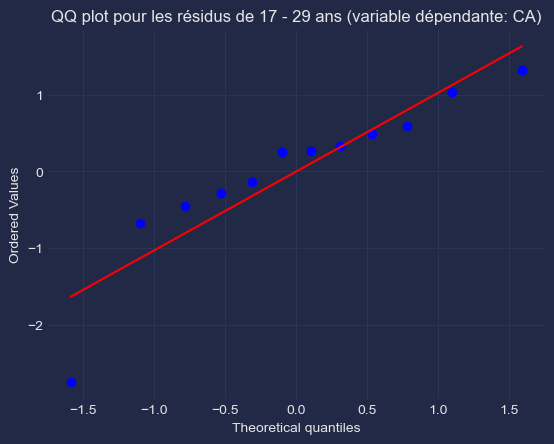

Normalité des résidus pour 30 - 49 ans (variable dépendante: CA): p-valeur = 0.7331958650245338
Échec à rejeter l'hypothèse nulle: Les résidus pour 30 - 49 ans sont normalement distribués.


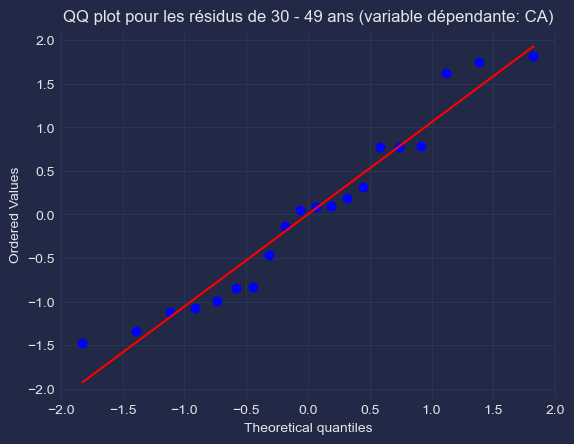

Normalité des résidus pour 50 - plus (variable dépendante: CA): p-valeur = 0.2515701549082545
Échec à rejeter l'hypothèse nulle: Les résidus pour 50 - plus sont normalement distribués.


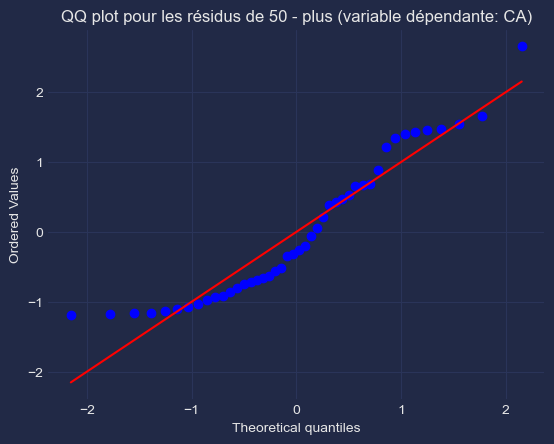

Test d'homoscédasticité de Levene : p-valeur = 0.036671365756131453
Rejet de l'hypothèse nulle : Les variances ne sont PAS égales entre les groupes, l'hypothèse d'homoscédasticité n'est pas vérifiée.


In [83]:
# Créer une instance de la classe ResidualAnalysis en fournissant le DataFrame, la variable dépendante et la variable indépendante
analyse_residus = AnalyseResidus(df_particuliers, var_dependante="CA", var_independante="tranche")

# Utiliser la méthode analyser_residus pour vérifier la normalité et l'homoscédasticité des résidus pour chaque catégorie
analyse_residus.analyser_residus()


#### Nous allons réaliser une ANOVA de Welch et un test post-hoc de Games-Howell.

Le test post-hoc de Games-Howell est utilisé pour effectuer des comparaisons multiples entre les groupes, en particulier lorsque les conditions d'homoscédasticité ne sont pas respectées. Il permet d'identifier les différences significatives entre les paires de groupes en tenant compte des inégalités de variances, offrant ainsi une analyse complémentaire à l'ANOVA de Welch.

    Source  ddof1      ddof2          F         p-unc       np2
0  tranche      2  32.217623  130.04854  3.729670e-16  0.758483
Il y a une différence significative entre les moyennes des groupes.


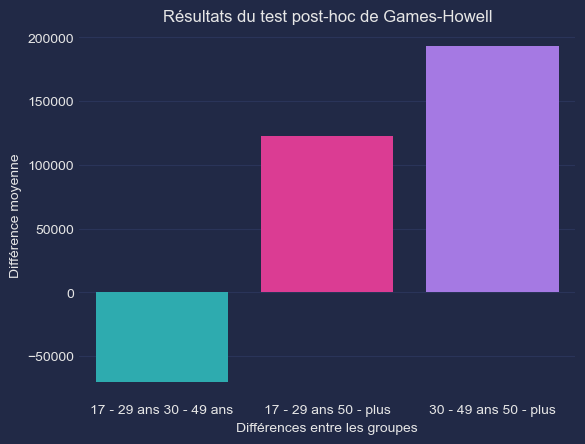

In [84]:
# Effectuer le test ANOVA de Welch et le test post-hoc de Games-Howell
variable_dependante = "CA"
variable_independante = "tranche"
alpha = 0.05  # Niveau de signification pour le test d'hypothèse
anova_gameshowell(df_particuliers, variable_dependante, variable_independante, alpha)


**$H_0$** est rejetée. Les différences de moyennes sont significatives, il existe un lien entre l'âge et le montant total du panier.


### 3.2.2.	La fréquence d’achat

## Question : y a-t-il un lien entre l'âge des clients et la fréquence des achats?

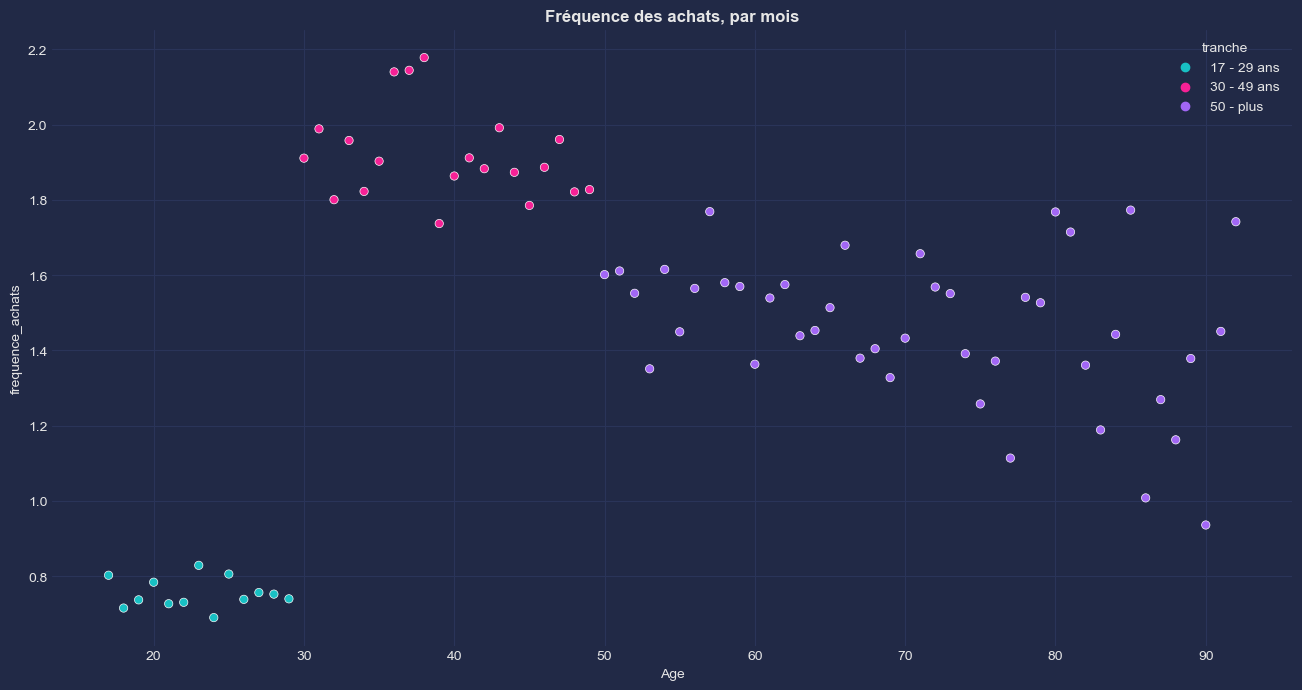

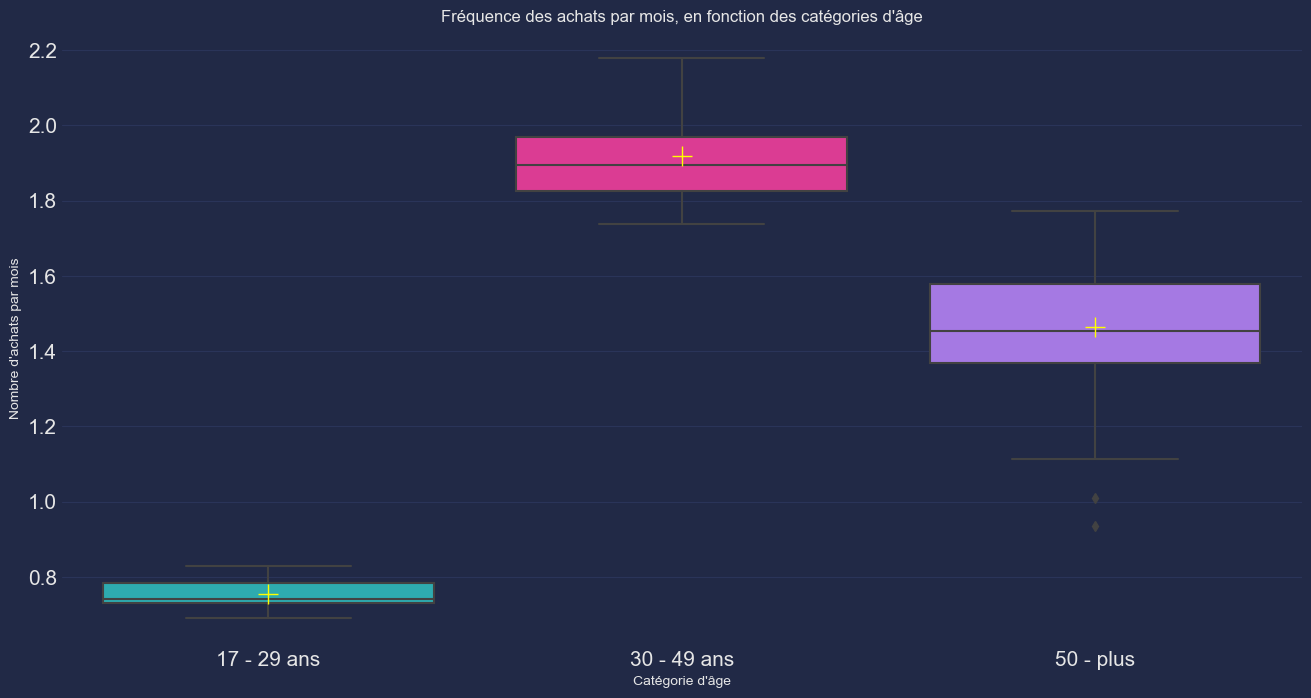

In [85]:
# Copie le DataFrame "df_corr" dans un nouveau DataFrame "df".
df = df_corr.copy()

# Convertit les dates en format de date uniquement (en supprimant l'heure) dans la colonne "date".
df["date"] = df["date"].dt.date

# Groupe les données par "client_id" et "date", puis calcule la somme du prix et conserve les premières valeurs de "session_id", "Age" et "tranche".
# Ensuite, groupe à nouveau les données par "client_id" et calcule le nombre total de sessions et la somme des prix pour chaque client, tout en conservant les premières valeurs de "Age" et "tranche".
df = (
    df
    .groupby(["client_id", "date"])
    .agg({"session_id": "first", "price": "sum", "Age": "first", "tranche": "first"})
    .groupby(["client_id"])
    .agg({"session_id": "count", "price": "sum", "Age": "first", "tranche": "first"})
    .reset_index()
)

# Calcule le nombre de mois entre la date la plus récente et la date la plus ancienne dans le DataFrame "df_central".
mois = (df_central["date"].max() - df_central["date"].min()).days / 30

# Calcule la fréquence d'achat et le panier moyen pour chaque client en fonction du nombre de mois et du prix total dépensé.
df["frequence_achats"] = df["session_id"] / mois
df["panier_moyen"] = df["price"] / df["session_id"]

# Groupe les données par "Age" et calcule la moyenne des sessions, du panier moyen et de la fréquence d'achat pour chaque tranche d'âge, tout en conservant la première valeur de la colonne "tranche".
df_age_fq = df.groupby("Age").agg({"session_id": "mean", "panier_moyen": "mean", "frequence_achats": "mean", "tranche": "first"}).reset_index()


#scatter plot
fig = plt.figure(num=None, figsize=(16,8))

sns.scatterplot( x= df_age_fq["Age"],y = df_age_fq["frequence_achats"], hue=df_age_fq["tranche"])
plt.title("Fréquence des achats, par mois",fontsize = 12, fontweight='bold')
plt.show()
meanprops = {"marker":"+", "markeredgecolor":"yellow", "markersize":15}

fig = plt.figure(num=None, figsize=(16,8))

sns.boxplot(x=df_age_fq["tranche"], y=df_age_fq["frequence_achats"], showmeans=True, meanprops=meanprops) # D
plt.title("Fréquence des achats par mois, en fonction des catégories d'âge")
plt.ylabel("Nombre d'achats par mois")
plt.xlabel("Catégorie d'âge")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

•	On peut ici observer qu'il n'y a pas l'air d'avoir de relation linéaire présente.

•	La discrétisation en catégorie d'âge nous montre qu'il y a effectivement l’air d'avoir des différences entre les différents groupes même si les ordres de grandeur sont petits.

•	 Nous vous allons donc voir par le calcul si ces différences sont significatives.


- **$H_0$** : les différences entre les groupes ne sont pas significatives : •	Il n'y a pas de lien entre l'**âge** et la **fréquence d'achat**.

- **$H_1$** : •	Il existe un lien entre l'**âge des clients** et la **fréquence d'achat**.

#### Nous sommes ici en présence d'une variable qualitative et d'une variable quantitative nous allons donc voir si nous pouvons procéder à une ANOVA. 

Normalité des résidus pour 17 - 29 ans (variable dépendante: frequence_achats): p-valeur = 0.6896579192727267
Échec à rejeter l'hypothèse nulle: Les résidus pour 17 - 29 ans sont normalement distribués.


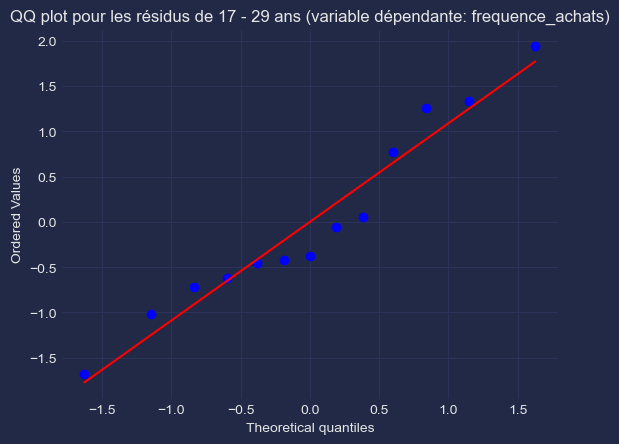

Normalité des résidus pour 30 - 49 ans (variable dépendante: frequence_achats): p-valeur = 0.5114887407167186
Échec à rejeter l'hypothèse nulle: Les résidus pour 30 - 49 ans sont normalement distribués.


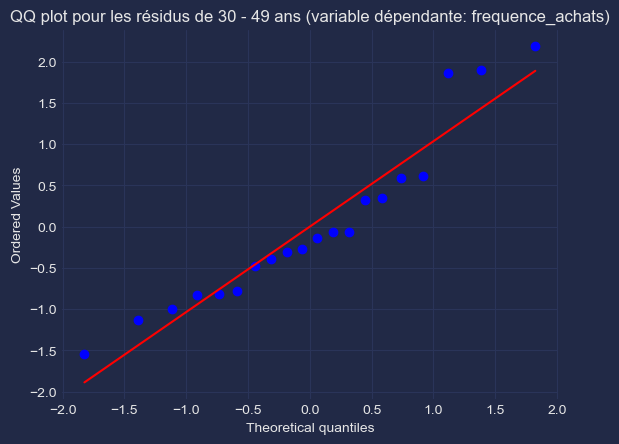

Normalité des résidus pour 50 - plus (variable dépendante: frequence_achats): p-valeur = 0.808899923325542
Échec à rejeter l'hypothèse nulle: Les résidus pour 50 - plus sont normalement distribués.


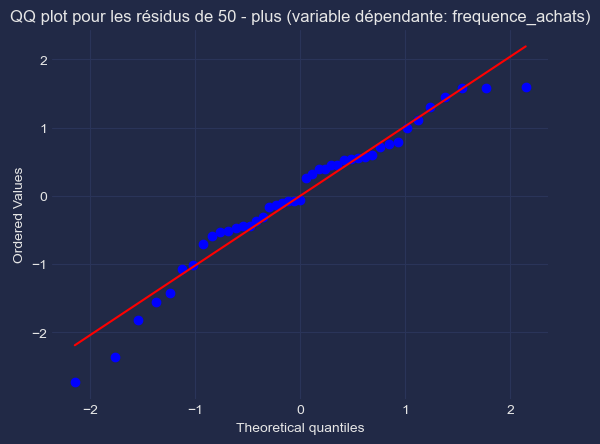

Test d'homoscédasticité de Levene : p-valeur = 0.0007377437092475575
Rejet de l'hypothèse nulle : Les variances ne sont PAS égales entre les groupes, l'hypothèse d'homoscédasticité n'est pas vérifiée.


In [86]:
# Créer une instance de la classe ResidualAnalysis en fournissant le DataFrame, la variable dépendante et la variable indépendante
analyse_residus = AnalyseResidus(df_age_fq, var_dependante="frequence_achats", var_independante="tranche")

# Utiliser la méthode analyser_residus pour vérifier la normalité et l'homoscédasticité des résidus pour chaque catégorie
analyse_residus.analyser_residus()


    Source  ddof1      ddof2           F         p-unc       np2
0  tranche      2  41.899907  922.441057  2.285970e-35  0.848994
Il y a une différence significative entre les moyennes des groupes.


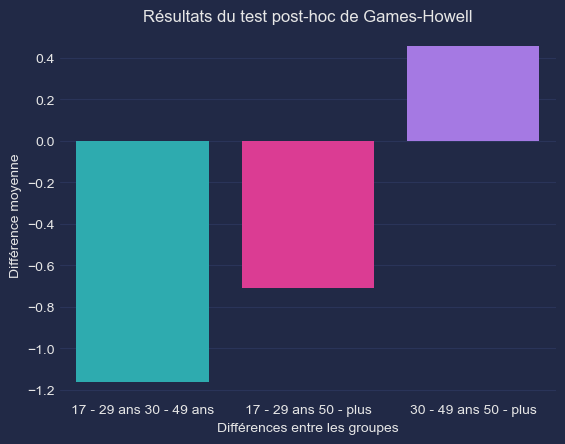

In [87]:
# Effectuer le test ANOVA de Welch et le test post-hoc de Games-Howell
variable_dependante = "frequence_achats"
variable_independante = "tranche"
alpha = 0.05  # Niveau de signification pour le test d'hypothèse
anova_gameshowell(df_age_fq, variable_dependante, variable_independante, alpha)

**$H_0$** est rejetée. Il existe un lien entre l'âge et la fréquence des achats.

### 3.2.3.	La taille du panier moyen 

## Question : y a-t-il un lien entre l'âge des clients et la taille du panier moyen ?

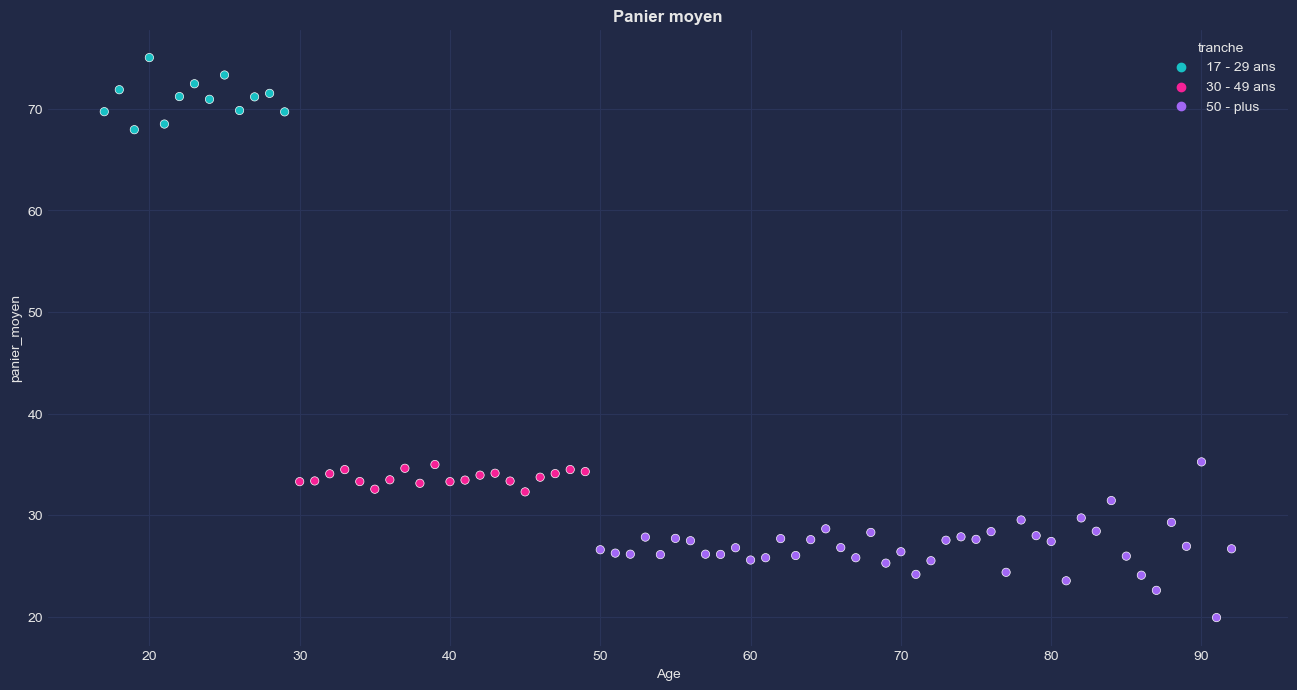

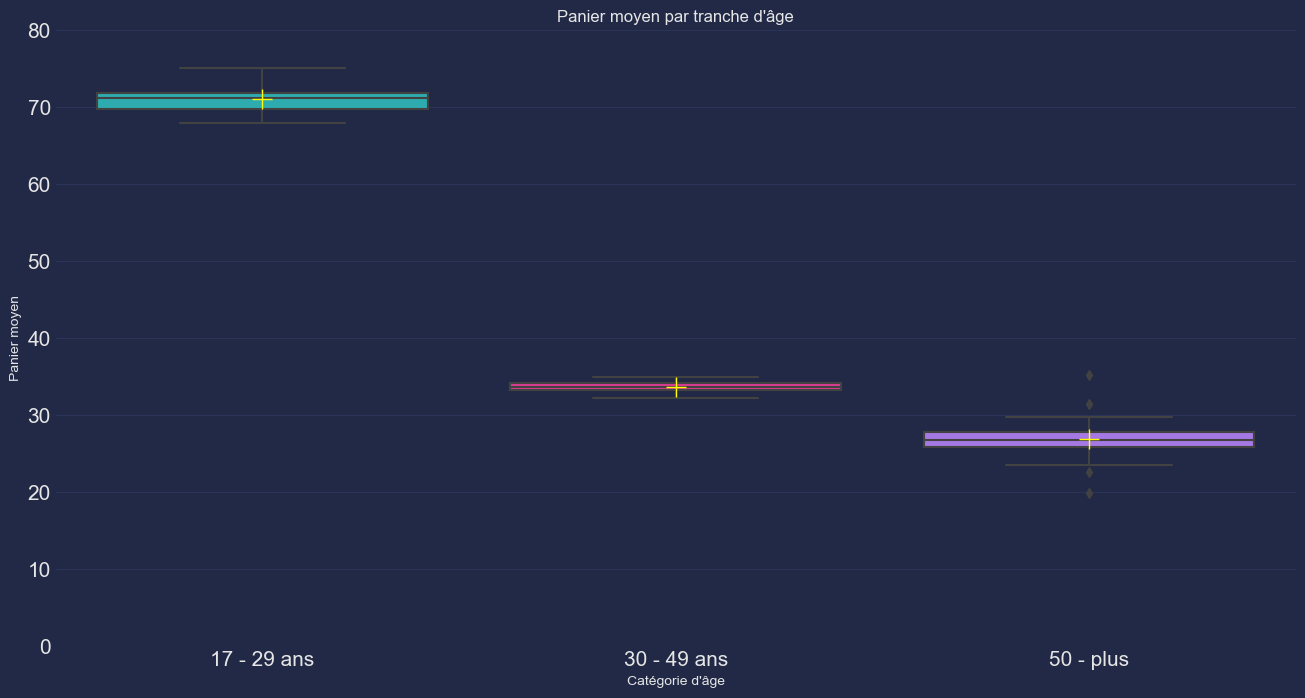

In [88]:
fig = plt.figure(num=None, figsize=(16,8))

sns.scatterplot( x= df_age_fq["Age"],y = df_age_fq["panier_moyen"], hue = df_age_fq["tranche"])
plt.title("Panier moyen",fontsize = 12, fontweight='bold')
plt.show()
fig = plt.figure(num=None, figsize=(16,8))

meanprops = {"marker":"+", "markeredgecolor":"yellow", "markersize":15}
sns.boxplot(x= df_age_fq["tranche"], y= df_age_fq["panier_moyen"], showmeans=True, meanprops=meanprops)
plt.title("Panier moyen par tranche d'âge")
plt.ylabel("Panier moyen")
plt.xlabel("Catégorie d'âge")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0, 80) 
plt.show()

•	On peut observer qu'il n'y a pas l'air d'avoir de relation linéaire présente il y a effectivement l’air d'avoir des différences entre les différents groupes.

•	 Nous vous allons donc voir par le calcul si ces différences sont significatives.


- **$H_0$** : les différences entre les groupes ne sont pas significatives :	Il n'y a pas de lien entre l'**âge** et le **panier moyen**.

- **$H_1$** : •	Il existe un lien entre l'**âge des clients** et la **panier moyen**.

#### Nous sommes ici en présence d'une variable qualitative et d'une variable quantitative nous allons donc voir si nous pouvons procéder à une ANOVA. 

Normalité des résidus pour 17 - 29 ans (variable dépendante: panier_moyen): p-valeur = 0.9775847487311781
Échec à rejeter l'hypothèse nulle: Les résidus pour 17 - 29 ans sont normalement distribués.


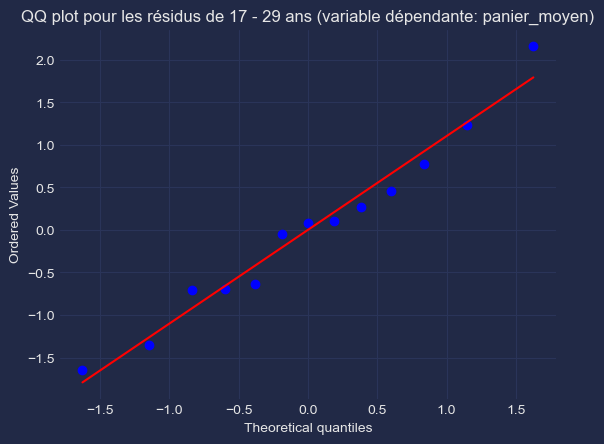

Normalité des résidus pour 30 - 49 ans (variable dépendante: panier_moyen): p-valeur = 0.7933091921277023
Échec à rejeter l'hypothèse nulle: Les résidus pour 30 - 49 ans sont normalement distribués.


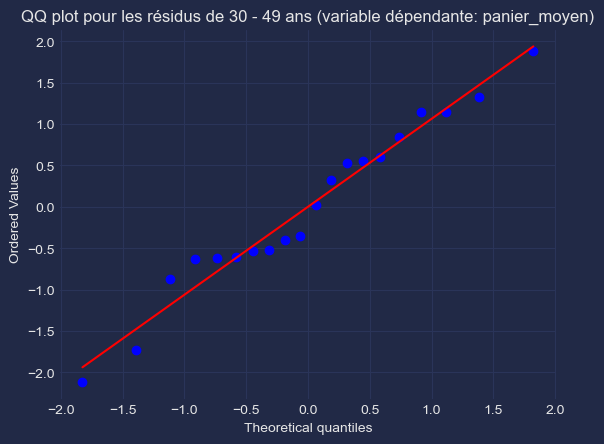

Normalité des résidus pour 50 - plus (variable dépendante: panier_moyen): p-valeur = 0.5205998990126293
Échec à rejeter l'hypothèse nulle: Les résidus pour 50 - plus sont normalement distribués.


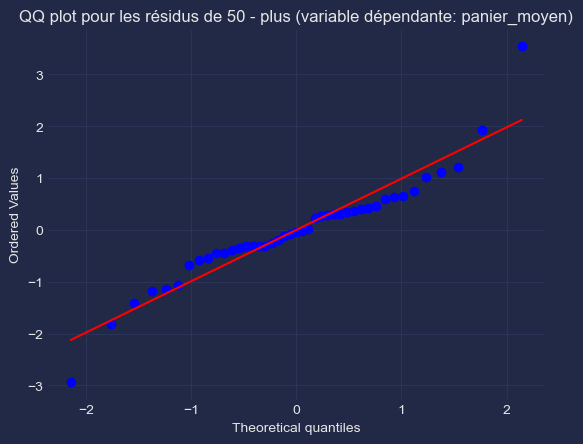

Test d'homoscédasticité de Levene : p-valeur = 0.023681259288196133
Rejet de l'hypothèse nulle : Les variances ne sont PAS égales entre les groupes, l'hypothèse d'homoscédasticité n'est pas vérifiée.


In [89]:
# Créer une instance de la classe ResidualAnalysis en fournissant le DataFrame, la variable dépendante et la variable indépendante
analyse_residus = AnalyseResidus(df_age_fq, var_dependante="panier_moyen", var_independante="tranche")

# Utiliser la méthode analyser_residus pour vérifier la normalité et l'homoscédasticité des résidus pour chaque catégorie
analyse_residus.analyser_residus()

    Source  ddof1     ddof2            F         p-unc       np2
0  tranche      2  28.77753  2459.101696  6.870444e-33  0.985213
Il y a une différence significative entre les moyennes des groupes.


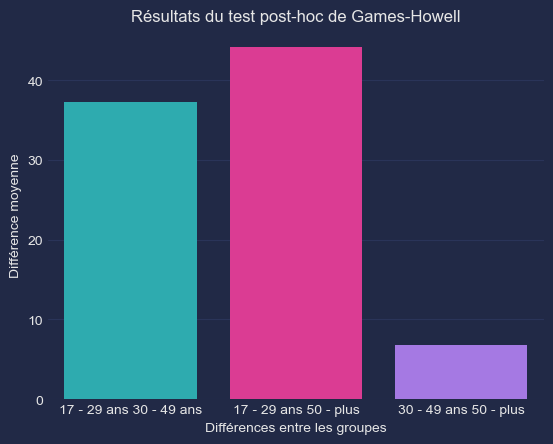

In [90]:
# Effectuer le test ANOVA de Welch et le test post-hoc de Games-Howell
variable_dependante = "panier_moyen"
variable_independante = "tranche"
alpha = 0.05  # Niveau de signification pour le test d'hypothèse
anova_gameshowell(df_age_fq, variable_dependante, variable_independante, alpha)

**$H_0$** est rejetée. L'âge et le panier moyen sont liés.

### 3.2.4. 	Les catégories des livres achetés

## Question : y a-t-il un lien entre l'âge des clients et les catégories de livres achetés ?

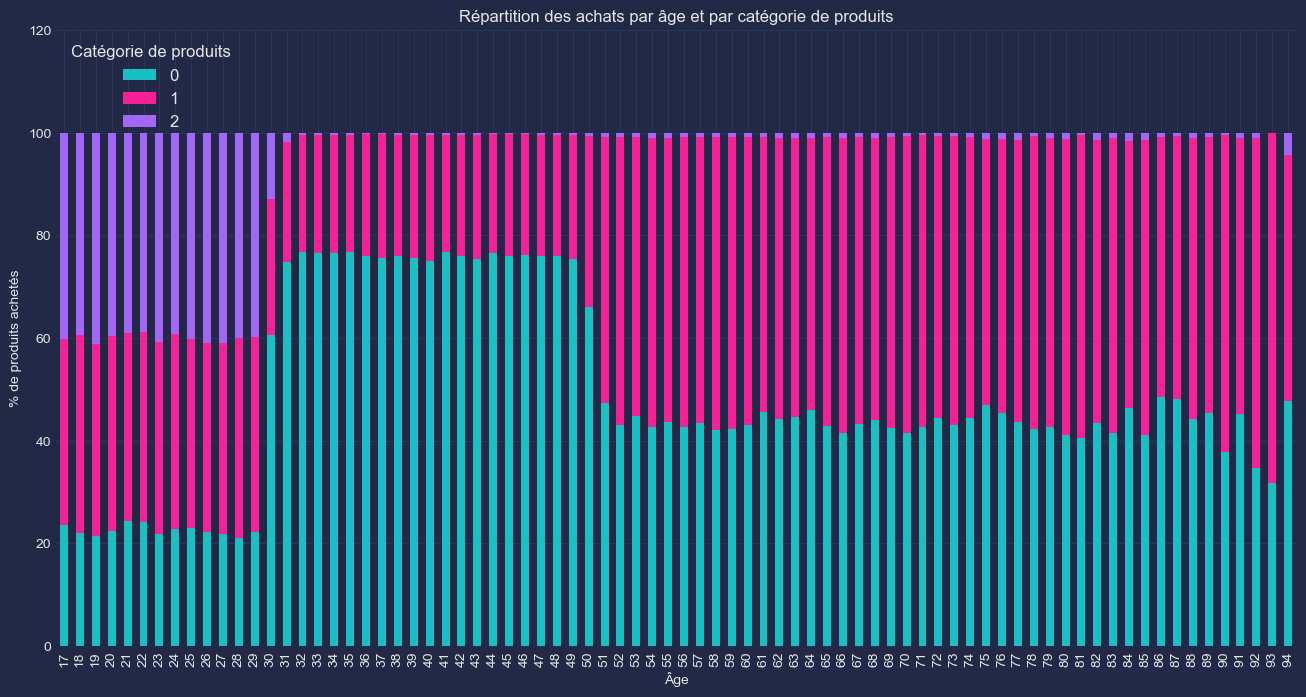

In [91]:
# Crée une table pivot à partir du DataFrame "df_corr" en utilisant les colonnes "Age" et "categ", en comptant le nombre d'occurrences pour chaque combinaison d'âge et de catégorie.
lien_age_categ = (
                df_corr[["Age", "categ"]]
                .pivot_table(
                index="Age",
                columns="categ",
                aggfunc=len,
            )
)

# Divise chaque ligne par la somme des valeurs de cette ligne, puis multiplie par 100 pour obtenir les pourcentages.
lien_age_categ = lien_age_categ.apply(lambda row: row / row.sum() * 100, axis=1)

# Crée une visualisation en graphique à barres empilées à partir de la table pivot normalisée "lien_age_categ".
ax = lien_age_categ.plot(kind="bar", stacked=True, figsize=(16,8))
ax.set_ylim([0, 120])
plt.title("Répartition des achats par âge et par catégorie de produits")
plt.xlabel("Âge")
plt.ylabel("% de produits achetés")
plt.legend(title="Catégorie de produits", fontsize=12, title_fontsize=12,loc="best")

plt.show()


Il semblerait y avoir des disparités dans la catégorie de livres achetés selon l'âge, la catégorie 2 par exemple semble être populaire chez les moins de 30 ans.

On voit aussi se dégager des tendances par catégorie d'âge on va donc ici considérer la variable âge comme étant de type qualitative.

- **$H_0$** : la catégorie de livres achetés ne dépend pas de l'âge du client . Les variables **Age** et **Catégorie** sont **indépendantes**.

- **$H_1$** : les 2 variables **Age** et **Catégorie** **sont liées.**


#### Nous sommes ici en présence de 2 variables qualitatives : nous allons donc procéder à un test d'indépendance du **$Chi-2$**.

Établissement d'un tableau de contingence pour croiser les modalités de nos variables : 

- **Catégorie** : variable dépendante placée en colonnes.
- **Age** : placé en ligne c'est notre variable indépendante.

In [92]:
# Création d'un tableau de contingence pour les deux variables.
tabl = pd.crosstab(
                    df_corr["tranche"],
                    df_corr["categ"],
                    margins=True,
                    margins_name="Total")
tabl

categ,0,1,2,Total
tranche,,,,
17 - 29 ans,15938,26610,28361,70909
30 - 49 ans,292302,91549,2948,386799
50 - plus,79253,94189,1539,174981
Total,387493,212348,32848,632689


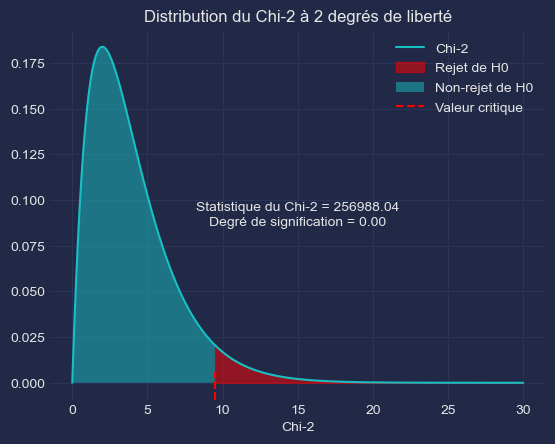

In [93]:
# Définition du risque standard
alpha = 0.05

# Calcul du khi2, de la p-value, du degré de liberté et des valeurs attendues Cij
khi2, pval, dof, expected = ss.chi2_contingency(tabl.iloc[:-1, :-1])
# Calcul de la valeur critique
crit_val = ss.chi2.ppf(1-alpha, dof)
khi2, pval, dof, expected 


# Définition des valeurs de l'axe x
x = np.linspace(0, 30, 1000)

y = ss.chi2.pdf(x, dof)

# Visualisation de la distribution du Chi-2 à 2 degrés de liberté
plt.plot(x, y, label='Chi-2')

# Coloration de la région de rejet
x_rejet = np.linspace(crit_val, x[-1], 1000)
plt.fill_between(x_rejet, ss.chi2.pdf(x_rejet, dof), color='red', alpha=0.5, label='Rejet de H0')

# Coloration de la région de non-rejet
x_nonrejet = np.linspace(x[0], crit_val, 1000)
plt.fill_between(x_nonrejet, ss.chi2.pdf(x_nonrejet, dof), alpha=0.5, label='Non-rejet de H0')

# Traçage de la valeur critique
plt.axvline(x=crit_val, color='red', linestyle='--', label='Valeur critique', ymax=np.interp(crit, x, y))


# Définition du titre et des étiquettes des axes x et y
plt.title('Distribution du Chi-2 à 2 degrés de liberté')
plt.xlabel('Chi-2')

# Affichage de la statistique du test du Chi-2 et du degré de signification
plt.text(max(x)/2, max(y)/2, f'Statistique du Chi-2 = {khi2:.2f}\nDegré de signification = {pval:.2f}', ha='center', va='center')

# Affichage de la légende
plt.legend()
plt.show()

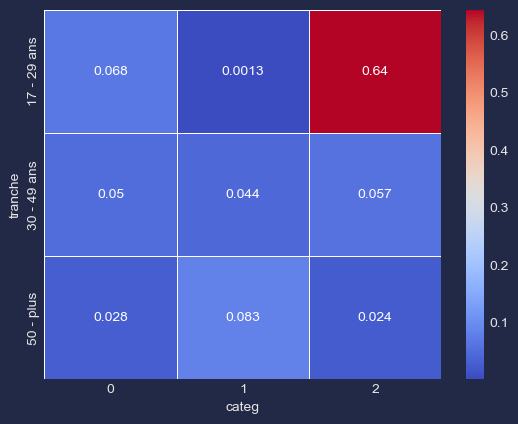

In [94]:
#  
cont = (tabl.iloc[:-1, :-1] - expected)**2 / expected 
tableau_contr = cont / khi2 
sns.heatmap(tableau_contr, annot=True, linewidths=.5, cmap="coolwarm")
plt.show() 

Les ventes de la catégorie 2 pour les 17-29 ans contribuent ici le plus à la dépendance des variables.

On peut identifier trois groupes d'âge :

- Les 17-29 ans : ils ont la fréquence d'achat la plus basse, mais le panier moyen le plus élevé.
Ils sont intéressés par les trois catégories de livres, particulièrement  par la catégorie 2 comparativement aux autres groupes.

- Les 30-49 ans : ils ont la fréquence d'achat la plus élevée et sont particulièrement intéressés par les livres de la catégorie 0.

    
- Les 50 ans et plus : ils ont le panier moyen le plus faible et génèrent le moins de chiffre d'affaires.
    Ils ont un intérêt égal pour les catégories 0 et 1.